In [2]:
import mysql.connector
import os
import pandas as pd
import numpy as np
import shap
from numpy import sort
import timeit
import time        
import datetime
import re
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, auc, roc_curve, precision_recall_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.linear_model import LogisticRegression
#from yellowbrick.classifier import ROCAUC
import plotly.graph_objects as go
from probatus.interpret import ShapModelInterpreter
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBClassifier
import configparser
import pymysql
from openpyxl.chart import BarChart, Reference
import openpyxl
from openpyxl.drawing.image import Image 
import helper_functions as hf

In [4]:
config = configparser.ConfigParser()
config.read('.my.cnf')
db_config = config['mysqlconnection']

# 0. Importing Sentilink Scores 

In [ ]:
## Could be outdated
## Import and merge as needed
## Need to run a different df ('XXXX') first to get the lsid range
iters=200
conn = pymysql.connect(host=db_config['host'],
                       user=db_config['user'],
                       password=db_config['password'],
                       database=db_config['database'])
for i in range(iters):
    time1=time.time()
    temp =  pd.read_sql("""
    SELECT lead_sequence_id, `/sentilink/i/scores/sas/score` as org3s, `/sentilink/i/scores/stpss/score` as org2s, `/sentilink/i/scores/stpss/score` as org4s
    FROM datawork.mk_sentilink
    WHERE lead_sequence_id in """ + str(tuple('XXXX'.lead_sequence_id[(i*np.floor(len('XXXX')/iters)).astype(int):((i+1)*np.floor(len('XXXX')/iters)).astype(int)].to_list())) + """
    ;""", con = conn)
    print(time.time()-time1)
    print(i)
    print(temp.shape)
    if i==0:
        Sentilink_org_score_df = temp.copy()
    else:
        Sentilink_org_score_df = pd.concat([Sentilink_org_score_df, temp], ignore_index=True)

# 1. HB1 Accepts: no_contact // isF2PD

## 1.1 Data and Variable Creation

In [10]:
## If you do not have this pkl downloaded you can use the code at the begginning of the other Sentilink notebook using the csv's
df = pd.read_pickle('Sentilink_model_df.pkl')

In [12]:
## df with every accepted customer (hb1 accept)
df_hb1 = df[df['decision'] == 1]

In [14]:
## df with every customer that has originated
df_isOrig = df[df['isorigination'] == 1]
df_isOrig.shape

(75113, 274)

In [16]:
print(df['decision'].value_counts())
print(df_hb1['decision'].value_counts())

decision
0.0    4006134
1.0    1303853
Name: count, dtype: int64
decision
1.0    1303853
Name: count, dtype: int64


In [18]:
print(df['isorigination'].value_counts())
print(df_isOrig['isorigination'].value_counts())

isorigination
0    5234887
1      75113
Name: count, dtype: int64
isorigination
1    75113
Name: count, dtype: int64


In [20]:
iters=200
conn = pymysql.connect(host=db_config['host'],
                       user=db_config['user'],
                       password=db_config['password'],
                       database=db_config['database'])

for i in range(iters):
    time1=time.time()
    temp =  pd.read_sql("""
    SELECT b.lead_sequence_id, a.withdrawn_reason
    FROM dwh.rpt_leads_accepted a
    LEFT JOIN datawork.mk_application b ON a.lead_sequence_id = b.lead_sequence_id
    WHERE b.lead_sequence_id in """ + str(tuple(df_hb1.lead_sequence_id[(i*np.floor(len(df_hb1)/iters)).astype(int):((i+1)*np.floor(len(df_hb1)/iters)).astype(int)].to_list())) + """
    ;""", con = conn)
    print(time.time()-time1)
    print(i)
    print(temp.shape)
    if i==0:
        nocont_df = temp.copy()
    else:
        nocont_df = pd.concat([nocont_df, temp], ignore_index=True)

/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_98449/2619134150.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  temp =  pd.read_sql("""


1.4772181510925293
0
(6509, 2)
0.4973256587982178
1
(6511, 2)
0.5170471668243408
2
(6510, 2)
0.4203672409057617
3
(6501, 2)
0.4523921012878418
4
(6505, 2)
0.4054131507873535
5
(6509, 2)
0.48082923889160156
6
(6507, 2)
0.4390900135040283
7
(6505, 2)
0.4958839416503906
8
(6511, 2)
0.4329867362976074
9
(6509, 2)
0.47279906272888184
10
(6507, 2)
0.4503779411315918
11
(6505, 2)
0.409027099609375
12
(6511, 2)
0.42861104011535645
13
(6505, 2)
0.4141428470611572
14
(6509, 2)
0.4652402400970459
15
(6508, 2)
0.42833781242370605
16
(6509, 2)
0.4768996238708496
17
(6512, 2)
0.42760396003723145
18
(6508, 2)
0.4538757801055908
19
(6512, 2)
0.44769287109375
20
(6504, 2)
0.41446495056152344
21
(6511, 2)
0.462172269821167
22
(6507, 2)
0.37700510025024414
23
(6514, 2)
0.4564180374145508
24
(6511, 2)
0.44636106491088867
25
(6506, 2)
0.43120527267456055
26
(6508, 2)
0.41269826889038086
27
(6514, 2)
0.4386129379272461
28
(6512, 2)
0.45278382301330566
29
(6507, 2)
0.42911291122436523
30
(6509, 2)
0.46293401

In [22]:
df_hb1 = pd.merge(left=df_hb1, right=nocont_df, on='lead_sequence_id', how='left')
df_hb1.shape

(1303853, 275)

### no_contact

In [24]:
## found every target that indicated no_contact or was fraud'y' and made them 0 (since they are the minority class)
## 0 is bad? Check this for when combining with isF2PD to make sure the 0's and 1's align regarding their connotation
df_hb1['no_contact']=1
df_hb1.loc[df_hb1.withdrawn_reason.str.lower().str.contains('auto-withdraw|unable to contact|refused to verify account information|possible fraud|badcontactinfo|bad contact information|refused to provide payment method'
                                                            , na=False),['no_contact']]=0

In [26]:
df_hb1.shape

(1303853, 276)

In [28]:
df_hb1['no_contact'].value_counts(dropna = False)

no_contact
0    1095585
1     208268
Name: count, dtype: int64

In [30]:
df_hb1.withdrawn_reason.str.lower().value_counts(normalize = True, dropna = False)

withdrawn_reason
auto-withdraw                                                                                                   0.838370
None                                                                                                            0.093874
customer withdrawn by underwriting                                                                              0.038995
no longer interested                                                                                            0.005246
invalid pay frequency                                                                                           0.005103
minimum income not met                                                                                          0.004517
unable to verify account information                                                                            0.001825
invalid bank account type                                                                                       0.001610
fees too high  

In [32]:
df_hb1[df_hb1['no_contact'] == 0].withdrawn_reason.value_counts(dropna = False)

withdrawn_reason
Auto-Withdraw                            1093111
Refused to verify account information       1533
Possible Fraud                               538
Bad Contact Information                      396
Refused to Provide Payment Method              7
Name: count, dtype: int64

'organization_id',
 'decision',
 'isorigination',
 'base_loan_id',
 'isFPD',
 'Ever_30DPD_in_90',
 'decile',
 'MK2rs',
 'cbbrs',
 'cfirs',
 'withdrawn_reason',
 'no_contact'

In [35]:
iters=200
conn = pymysql.connect(host=db_config['host'],
                       user=db_config['user'],
                       password=db_config['password'],
                       database=db_config['database'])

for i in range(iters):
    time1=time.time()
    temp =  pd.read_sql("""
    SELECT a.lead_sequence_id, psi.item_date, psi.`status`, psi.total_amount
    FROM jaglms.lms_payment_schedule_items psi
    JOIN jaglms.lms_payment_schedules ps ON ps.payment_schedule_id = psi.payment_schedule_id
    JOIN jaglms.lms_base_loans b ON b.base_loan_id = ps.base_loan_id
    JOIN datawork.mk_application a ON a.loan_header_id = b.loan_header_id
    AND payment_sequence < 5
    AND item_date >= 2023-08-01
    AND psi.`status` != 'scheduled'
    AND psi.`status` != 'cancelled'
    AND total_amount > 0
    AND a.lead_sequence_id IN """ + str(tuple(df_isOrig.lead_sequence_id[(i*np.floor(len(df_isOrig)/iters)).astype(int):((i+1)*np.floor(len(df_isOrig)/iters)).astype(int)].to_list())) + """
    ;""", con = conn)
    print(time.time()-time1)
    print(i)
    print(temp.shape)
    if i==0:
        nrfp2_df = temp.copy()
    else:
        nrfp2_df = pd.concat([nrfp2_df, temp], ignore_index=True)

/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_98449/4169675075.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  temp =  pd.read_sql("""


0.4910109043121338
0
(6037, 4)
0.3782670497894287
1
(5784, 4)
0.4091169834136963
2
(6230, 4)
0.34700584411621094
3
(6056, 4)
0.33794116973876953
4
(6334, 4)
0.3494248390197754
5
(6433, 4)
0.276569128036499
6
(6343, 4)
0.4196147918701172
7
(6097, 4)
0.35279202461242676
8
(5932, 4)
0.36960411071777344
9
(6152, 4)
0.4419090747833252
10
(6166, 4)
0.3013131618499756
11
(6431, 4)
0.27515435218811035
12
(6332, 4)
0.4203503131866455
13
(6606, 4)
0.2727789878845215
14
(6288, 4)
0.2545478343963623
15
(6180, 4)
0.3720738887786865
16
(6123, 4)
0.24824905395507812
17
(5962, 4)
0.24440813064575195
18
(5771, 4)
0.26619887351989746
19
(6298, 4)
0.31072115898132324
20
(5959, 4)
0.2744729518890381
21
(6259, 4)
0.25854015350341797
22
(6372, 4)
0.3861548900604248
23
(6153, 4)
0.2503798007965088
24
(6470, 4)
0.2655520439147949
25
(6347, 4)
0.2798888683319092
26
(5851, 4)
0.27509188652038574
27
(6062, 4)
0.2373199462890625
28
(6302, 4)
0.26160383224487305
29
(6172, 4)
0.362595796585083
30
(6176, 4)
0.251334

### isF2PD

In [37]:
nrfp2_df

,lead_sequence_id,item_date,status,total_amount
0,2562763313,2023-09-05,cleared,46.40
1,2562763313,2023-09-19,cleared,52.80
2,2562763313,2023-10-03,cleared,107.94
3,2562763313,2023-10-17,cleared,110.08
4,2562763313,2023-10-31,return,107.86
...,...,...,...,...
1013829,2617616004,2024-06-20,cleared,99.59
1013830,2617616004,2024-07-03,cleared,99.44
1013831,2617616004,2024-07-18,cleared,99.29
1013832,2617616004,2024-08-01,cleared,99.15


In [39]:
nrfp2_df['status'].value_counts()

status
cleared     780744
return      145078
MISSED       69413
SENT         13383
bypass        4928
Return         176
sent            62
Cleared         25
PRENOTED        24
Returned         1
Name: count, dtype: int64

In [41]:
nrfp2_df = nrfp2_df.loc[nrfp2_df.status != 'SENT']
nrfp2_df = nrfp2_df.loc[nrfp2_df.status != 'bypass']
nrfp2_df = nrfp2_df.loc[nrfp2_df.status != 'sent']
nrfp2_df = nrfp2_df.loc[nrfp2_df.status != 'PRENOTED']

In [43]:
status_clean = {
    'return': 'missed',
    'MISSED': 'missed',
    'Return': 'missed',
    'Returned': 'missed',
    'cleared': 'made',
    'Cleared': 'made'
}

nrfp2_df['status_group'] = nrfp2_df['status'].map(status_clean)
print(nrfp2_df['status_group'].value_counts())
print(nrfp2_df.shape)

status_group
made      780769
missed    214668
Name: count, dtype: int64
(995437, 5)


In [45]:
nrfp2_sorted_df = nrfp2_df.sort_values(by=['lead_sequence_id', 'item_date'])
nrfp2_first2_df = nrfp2_sorted_df.groupby('lead_sequence_id').head(2)
nrfp2_first2_df

,lead_sequence_id,item_date,status,total_amount,status_group
0,2562763313,2023-09-05,cleared,46.40,made
1,2562763313,2023-09-19,cleared,52.80,made
9,2562773226,2023-08-20,cleared,65.00,made
10,2562773226,2023-09-07,return,62.00,missed
11821,2562804546,2023-09-06,return,535.01,missed
...,...,...,...,...,...
559180,2617617380,2024-05-03,cleared,202.00,made
568959,2617618272,2024-04-21,cleared,117.50,made
568960,2617618272,2024-05-09,cleared,117.32,made
568969,2617618300,2024-04-19,cleared,176.75,made


In [47]:
## If both first payments are classified as 'missed' then the lsid is given a 1
nrfp2_first2_df['isF2PD'] = nrfp2_first2_df.groupby('lead_sequence_id')['status_group'].transform(
    lambda x: 1 if all(x == 'missed') else 0
)

/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_98449/2267795488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nrfp2_first2_df['isF2PD'] = nrfp2_first2_df.groupby('lead_sequence_id')['status_group'].transform(


In [49]:
isF2pd_df = nrfp2_first2_df[['lead_sequence_id', 'isF2PD']].drop_duplicates()

In [51]:
print(isF2pd_df)
print(isF2pd_df['isF2PD'].value_counts(normalize = True))
print(isF2pd_df['isF2PD'].value_counts())

         lead_sequence_id  isF2PD
0              2562763313       0
9              2562773226       0
11821          2562804546       1
17             2562807448       0
38             2562812751       0
...                   ...     ...
1013825        2617616004       0
568950         2617616799       0
559179         2617617380       0
568959         2617618272       0
568969         2617618300       0

[72265 rows x 2 columns]
isF2PD
0    0.943043
1    0.056957
Name: proportion, dtype: float64
isF2PD
0    68149
1     4116
Name: count, dtype: int64


If first 2 payments are missed then delinquent (f2pd)

In [54]:
df_isOrig = pd.merge(left=df_isOrig, right=isF2pd_df, on='lead_sequence_id', how='left')
df_isOrig

,lead_sequence_id,address_city_matches_records,address_distance_from_most_recent_on_record_km,address_history_yrs,address_min_distance_from_known_addresses_km,address_num_apps_cluster,address_num_identities_w_address_120d_cluster,address_num_identities_w_address_1y_cluster,address_num_identities_w_address_30d_cluster,address_num_identities_w_address_60d_cluster,...,decision,isorigination,base_loan_id,isFPD,Ever_30DPD_in_90,decile,MK2rs,cbbrs,cfirs,isF2PD
0,2565632843,True,0.000000,1.125257,0.0,5.0,0.0,0.0,0.0,0.0,...,1.0,1,5619912.0,0.0,NaN,1.0,807.0,729.0,905.0,0.0
1,2565630199,True,5.387749,24.621492,0.0,12.0,0.0,1.0,0.0,0.0,...,1.0,1,5619850.0,0.0,NaN,1.0,565.0,805.0,772.0,0.0
2,2565625630,True,0.000000,1.535934,0.0,17.0,0.0,1.0,0.0,0.0,...,1.0,1,5619762.0,0.0,NaN,1.0,495.0,792.0,871.0,0.0
3,2565612372,True,0.000000,2.620123,0.0,18.0,1.0,1.0,1.0,1.0,...,1.0,1,5619473.0,0.0,NaN,1.0,806.0,862.0,939.0,0.0
4,2565612227,True,0.000000,4.125941,0.0,3.0,0.0,0.0,0.0,0.0,...,1.0,1,5619472.0,0.0,NaN,1.0,NaN,NaN,636.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75108,2616880417,True,0.000000,5.322382,0.0,8.0,1.0,1.0,1.0,1.0,...,1.0,1,NaN,NaN,NaN,9.0,732.0,807.0,867.0,NaN
75109,2616880211,True,0.000000,0.073922,0.0,44.0,2.0,4.0,1.0,2.0,...,1.0,1,7347583.0,1.0,1.0,9.0,600.0,762.0,754.0,NaN
75110,2616874480,True,0.696258,3.570157,0.0,5.0,0.0,0.0,0.0,0.0,...,1.0,1,7347277.0,1.0,1.0,9.0,297.0,811.0,728.0,NaN
75111,2616870945,True,1477.396835,6.075291,0.0,27.0,0.0,0.0,0.0,0.0,...,1.0,1,7347115.0,0.0,0.0,9.0,576.0,769.0,855.0,NaN


In [56]:
print(df_isOrig['isFPD'].value_counts(normalize = True))
print(df_isOrig['isF2PD'].value_counts(normalize = True))
print(df_isOrig['isFPD'].isna().sum())
print(df_isOrig['isF2PD'].isna().sum())

isFPD
0.0    0.915948
1.0    0.084052
Name: proportion, dtype: float64
isF2PD
0.0    0.944111
1.0    0.055889
Name: proportion, dtype: float64
1147
1127


### no_contact_andor_isF2PD

In [58]:
## Not sure why I named this df_isOrig as we are keeping all of the hb1 accept records 
df_isOrig1 = df_isOrig.merge(df_hb1[['lead_sequence_id', 'no_contact']], on='lead_sequence_id', how='right')
df_isOrig1

,lead_sequence_id,address_city_matches_records,address_distance_from_most_recent_on_record_km,address_history_yrs,address_min_distance_from_known_addresses_km,address_num_apps_cluster,address_num_identities_w_address_120d_cluster,address_num_identities_w_address_1y_cluster,address_num_identities_w_address_30d_cluster,address_num_identities_w_address_60d_cluster,...,isorigination,base_loan_id,isFPD,Ever_30DPD_in_90,decile,MK2rs,cbbrs,cfirs,isF2PD,no_contact
0,2565634858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2565633125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2565632843,True,0.0,1.125257,0.0,5.0,0.0,0.0,0.0,0.0,...,1.0,5619912.0,0.0,NaN,1.0,807.0,729.0,905.0,0.0,1
3,2565632798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2565631588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307390,2616974504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1307391,2616974315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1307392,2616974274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1307393,2616974268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [60]:
## This will cause a disturbance in the population / normalized count for isF2PD, so for the real distribution use df_isOrig, but is 
## alright since we are 'adding' no_contact cells and isF2PD cells (+0 will do nothing to the outcome)

df_isOrig1['isF2PD'] = df_isOrig1['isF2PD'].fillna(0).astype(int)
df_isOrig1

,lead_sequence_id,address_city_matches_records,address_distance_from_most_recent_on_record_km,address_history_yrs,address_min_distance_from_known_addresses_km,address_num_apps_cluster,address_num_identities_w_address_120d_cluster,address_num_identities_w_address_1y_cluster,address_num_identities_w_address_30d_cluster,address_num_identities_w_address_60d_cluster,...,isorigination,base_loan_id,isFPD,Ever_30DPD_in_90,decile,MK2rs,cbbrs,cfirs,isF2PD,no_contact
0,2565634858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2565633125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2565632843,True,0.0,1.125257,0.0,5.0,0.0,0.0,0.0,0.0,...,1.0,5619912.0,0.0,NaN,1.0,807.0,729.0,905.0,0,1
3,2565632798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,2565631588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307390,2616974504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1307391,2616974315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1307392,2616974274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1307393,2616974268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


In [62]:
df_isOrig1['isF2PD'].isnull().sum()

0

In [64]:
df_isOrig1['no_contact'].value_counts()

no_contact
0    1095585
1     211810
Name: count, dtype: int64

In [66]:
df_isOrig1['no_contact_andor_isF2PD'] = (df_isOrig1['isF2PD'] | df_isOrig1['no_contact']).astype(int)
df_isOrig1

,lead_sequence_id,address_city_matches_records,address_distance_from_most_recent_on_record_km,address_history_yrs,address_min_distance_from_known_addresses_km,address_num_apps_cluster,address_num_identities_w_address_120d_cluster,address_num_identities_w_address_1y_cluster,address_num_identities_w_address_30d_cluster,address_num_identities_w_address_60d_cluster,...,base_loan_id,isFPD,Ever_30DPD_in_90,decile,MK2rs,cbbrs,cfirs,isF2PD,no_contact,no_contact_andor_isF2PD
0,2565634858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,2565633125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2,2565632843,True,0.0,1.125257,0.0,5.0,0.0,0.0,0.0,0.0,...,5619912.0,0.0,NaN,1.0,807.0,729.0,905.0,0,1,1
3,2565632798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
4,2565631588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307390,2616974504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
1307391,2616974315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
1307392,2616974274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
1307393,2616974268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1


In [78]:
print(df_isOrig1['isF2PD'].value_counts(normalize=True))
print(df_isOrig1['no_contact'].value_counts(normalize=True))
print(df_isOrig1['no_contact_andor_isF2PD'].value_counts(normalize=True))

isF2PD
0    0.996794
1    0.003206
Name: proportion, dtype: float64
no_contact
0    0.837991
1    0.162009
Name: proportion, dtype: float64
no_contact_andor_isF2PD
0    0.837989
1    0.162011
Name: proportion, dtype: float64


^^^^ Not very different from just 'no_contact' in hb1Accepts

## 1.2 Targets

Yet to do:
   - No contact: cfi? find good comparison - Ekata comparison - See if Senitlink features that are the same as Ekata are the same or
     better (less nulls)
   - Run model with Sentilink, find 10 best variables and how they perform in terms of no contact or isF2PD
   - Compare the worst 10% of Ekata and Sentilink (should have a large percentage of delinquent customers)
     isF2PD: mk2rs, cbb
   - The target / score models are below for each 'score' but for only no_contact and isF2PD

### 1.2.1 No Contact Model

In [82]:
## Deleting id columns; only keeping target and Sentilink features
df_hb1_nocont_sentilink = df_hb1.drop(columns=['lead_sequence_id', 'decision', 'organization_id', 'isorigination', 'base_loan_id', 'Ever_30DPD_in_90',
                               'isFPD', 'decile', 'MK2rs', 'cfirs', 'cbbrs', 'withdrawn_reason'])
df_hb1_nocont_sentilink.shape

(1303853, 264)

In [84]:
cols_binary  = []
for c in df_hb1_nocont_sentilink.columns[df_hb1_nocont_sentilink.dtypes == 'object']:
    if df_hb1_nocont_sentilink[c].nunique()<=2:
        print(c,df_hb1_nocont_sentilink[c].unique())
        cols_binary.append(c)

address_city_matches_records [True False nan]
applicant_has_bankruptcy_full_match [False True nan]
applicant_has_bankruptcy_w_another_ssn [False True nan]
applicant_has_fraud_victim_extended_alert [False nan True]
applicant_has_itin_history [False nan True]
applicant_is_best_email_owner_by_history_length [True nan False]
applicant_is_best_email_owner_by_recency [False nan True]
applicant_is_best_email_owner_by_usage [True nan False]
applicant_is_best_phone_owner_by_history [True False nan]
applicant_is_best_phone_owner_by_recency [True nan False]
applicant_likely_has_better_ssn [nan True False]
applicant_possible_same_name_fraud [False True nan]
applicant_shares_address_history_w_email_owner [nan False True]
email_and_address_match_different_identity_cluster [False True nan]
email_begins_with_middle_initial [False True nan]
email_common_domain [True False nan]
email_common_mail_dot_com [False nan True]
email_contains_dob [False True nan]
email_contains_duplicate_digits [False True nan]

In [86]:
def true_false_to_numeric(df, bool_col_list):
    #Normalize to lower case
    for col in bool_col_list:
        df[col] = df[col].astype(str).copy()
        df[col] = df[col].str.lower().copy()
        df.loc[df[col] == 'true',col] = 1
        df.loc[df[col] == 'y',col] = 1
        df.loc[df[col] == '1',col] = 1
        df.loc[df[col] == 'false',col] = 0
        df.loc[df[col] == 'n',col] = 0
        df.loc[df[col] == '0',col] = 0
        df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df.rename(columns = {col: col+'_bin'}, inplace = True)
    return df

In [88]:
print(df_hb1_nocont_sentilink.shape)
df_hb1_nocont_sentilink = true_false_to_numeric(df_hb1_nocont_sentilink, cols_binary)
print(df_hb1_nocont_sentilink.shape)

(1303853, 264)
(1303853, 264)


In [90]:
X = df_hb1_nocont_sentilink.drop(columns = ['no_contact'])
y = df_hb1_nocont_sentilink['no_contact']

X_hb1nc_sentilink_train, X_hb1nc_sentilink_other, y_hb1nc_sentilink_train, y_hb1nc_sentilink_other = train_test_split(X, y, test_size=0.3, random_state=42)
X_hb1nc_sentilink_vald, X_hb1nc_sentilink_test, y_hb1nc_sentilink_vald, y_hb1nc_sentilink_test = train_test_split(X_hb1nc_sentilink_other, y_hb1nc_sentilink_other, test_size=0.5, random_state=42)

In [92]:
print(y_hb1nc_sentilink_train.value_counts())
print(y_hb1nc_sentilink_train.value_counts(normalize = True))

no_contact
0    766932
1    145765
Name: count, dtype: int64
no_contact
0    0.840292
1    0.159708
Name: proportion, dtype: float64


In [94]:
print(y_hb1nc_sentilink_test.value_counts())
print(y_hb1nc_sentilink_test.value_counts(normalize = True))

no_contact
0    164361
1     31217
Name: count, dtype: int64
no_contact
0    0.840386
1    0.159614
Name: proportion, dtype: float64


In [96]:
model_hb1nc_sentilink = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_hb1nc_sentilink.fit(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [98]:
y_pred_hb1nc_sentilink = model_hb1nc_sentilink.predict(X_hb1nc_sentilink_test)
y_pred_prob_hb1nc_sentilink = model_hb1nc_sentilink.predict_proba(X_hb1nc_sentilink_test)[:, 1]
accuracy_hb1nc_sentilink = accuracy_score(y_hb1nc_sentilink_test, y_pred_hb1nc_sentilink)
roc_auc_hb1nc_sentilink = roc_auc_score(y_hb1nc_sentilink_test, y_pred_prob_hb1nc_sentilink)
precision, recall, thresholds = precision_recall_curve(y_hb1nc_sentilink_test, y_pred_prob_hb1nc_sentilink, pos_label=1)

print('AUC PR score for hb1 no contact sentilink: ' + str(metrics.auc(recall, precision)))
print(f"Accuracy score for hb1 no contact sentilink: {accuracy_hb1nc_sentilink}")
print(f"ROC AUC Score for hb1 no contact sentilink: {roc_auc_hb1nc_sentilink}")

AUC PR score for hb1 no contact sentilink: 0.3240125566354401
Accuracy score for hb1 no contact sentilink: 0.8416181779136712
ROC AUC Score for hb1 no contact sentilink: 0.6906057061745975


 - AUC PR from ~0.1597 (decent lift/value)

In [102]:
# calculate 'scale_pos_weight' as sum(negative class)/sum(positive class)
scale_pos_weight = y_hb1nc_sentilink_train.value_counts()[0] / y_hb1nc_sentilink_train.value_counts()[1]
round(scale_pos_weight,2)

5.26

In [ ]:
eval_set = [(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train), (X_hb1nc_sentilink_vald, y_hb1nc_sentilink_vald)]

def train_model(n_estimators, subsample, reg_lambda, reg_alpha, min_child_weight, max_depth, learning_rate, colsample_bytree):
    params = {
        'n_estimators': int(round(n_estimators)),
        'subsample': subsample,
        'reg_lambda': int(round(reg_lambda)),
        'reg_alpha': int(round(reg_alpha)),
        'min_child_weight': round(min_child_weight),
        'max_depth': int(round(max_depth)),
        'learning_rate': learning_rate,
        'colsample_bytree': colsample_bytree
    }
    xgbc_hb1nc = XGBClassifier(n_jobs = -1, eval_metric = ['error','aucpr'], early_stopping_rounds=20, objective='binary:logistic', **params, scale_pos_weight = scale_pos_weight)
    xgbc_hb1nc.fit(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train, eval_set=eval_set, verbose=50)
    return xgbc_hb1nc.evals_result()['validation_1']['aucpr'][-1]

xgb_param_grid = {
    'n_estimators' : (50, 201),
    'subsample': (0.7, 0.95),
    'reg_lambda': (1, 60),
    'reg_alpha': (1, 20), 
    'min_child_weight':(10, 51),
    'max_depth' : (2, 3),
    'learning_rate' : (0.01, 0.2),
    'colsample_bytree': (0.6, 0.95)
}

optimizer = BayesianOptimization(
    f=train_model,
    pbounds=xgb_param_grid,
    #random_state=1,
)
optimizer.maximize(init_points=2, n_iter=23)
 
print(optimizer.max)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[0]	validation_0-error:0.17548	validation_0-aucpr:0.25751	validation_1-error:0.17484	validation_1-aucpr:0.25923
[50]	validation_0-error:0.26675	validation_0-aucpr:0.30810	validation_1-error:0.26681	validation_1-aucpr:0.30670
[60]	validation_0-error:0.27471	validation_0-aucpr:0.30965	validation_1-error:0.27501	validation_1-aucpr:0.30796
| 1         | 0.308     | 0.6715    | 0.0724    | 2.156     | 34.01     | 61.31     | 6.129     | 20.12     | 0.9333    |
[0]	validation_0-error:0.17563	validation_0-aucpr:0.25748	validation_1-error:0.17497	validation_1-aucpr:0.25929
[50]	validation_0-error:0.26548	validation_0-aucpr:0.30857	validation_1-error:0.26566	validation_1-aucpr:0.30693
[100]	validation_0-error:0.29127	validation_0-aucpr:0.31357	validation_

In [120]:
xgbc_hb1nc.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.95,
 'device': None,
 'eval_metric': ['error', 'aucpr'],
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': 22.4,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 20.0,
 'reg_lambda': 12.48,
 'sampling_method': None,
 'scale_pos_weight': 5.261427640380064,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [91]:
print("Train full model with the best hyperparameter set...")
 
 
eval_set = [(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train), (X_hb1nc_sentilink_vald, y_hb1nc_sentilink_vald)]
xgbc_hb1nc = XGBClassifier(n_estimators = int(optimizer.max['params']['n_estimators']), 
                         n_jobs = -1, 
                         subsample = round(optimizer.max['params']['subsample'],2), 
                         reg_lambda = round(optimizer.max['params']['reg_lambda'],2), 
                         reg_alpha = round(optimizer.max['params']['reg_alpha'],2),
                         min_child_weight = round(optimizer.max['params']['min_child_weight'],2),
                         max_depth = int(optimizer.max['params']['max_depth']), 
                         learning_rate= round(optimizer.max['params']['learning_rate'],2),  
                         colsample_bytree = round(optimizer.max['params']['colsample_bytree'],2), 
                         scale_pos_weight = scale_pos_weight,
                         objective='binary:logistic',
                         eval_metric = ['error','aucpr'],
                         early_stopping_rounds=20
                        )
 
## model used for values below as it takes the best hyperparameter class 
xgbc_hb1nc.fit(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train, eval_set=eval_set, verbose=50)

#AUC
simple_split_pred_train = xgbc_hb1nc.predict_proba(X_hb1nc_sentilink_train)
fpr, tpr, thresholds = metrics.roc_curve(y_hb1nc_sentilink_train, simple_split_pred_train[:,1], pos_label=1)
print('AUC full train set: ' + str(metrics.auc(fpr, tpr)))
precision, recall, thresholds = precision_recall_curve(y_hb1nc_sentilink_train, simple_split_pred_train[:,1], pos_label=1)
print('AUC PR full train set: ' + str(metrics.auc(recall, precision)))
 
simple_split_pred_vald = xgbc_hb1nc.predict_proba(X_hb1nc_sentilink_vald)
fpr, tpr, thresholds = metrics.roc_curve(y_hb1nc_sentilink_vald, simple_split_pred_vald[:,1], pos_label=1)
print('AUC full vald set: ' + str(metrics.auc(fpr, tpr)))
precision, recall, thresholds = precision_recall_curve(y_hb1nc_sentilink_vald, simple_split_pred_vald[:,1], pos_label=1)
print('AUC PR full vald set: ' + str(metrics.auc(recall, precision)))
 
# simple_split_pred_test = xgbc_hb1nc.predict_proba(X_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, simple_split_pred_test[:,1], pos_label=1)
# print('AUC full test set: ' + str(metrics.auc(fpr, tpr)))
# precision, recall, thresholds = precision_recall_curve(y_test, simple_split_pred_test[:,1], pos_label=1)
# print('AUC PR full test set: ' + str(metrics.auc(recall, precision)))
 
binary_threshold_eval = thresholds[np.argmax(tpr-fpr)]
print('Threshold that generates max(tpr-fpr) for test population: ' + str(binary_threshold_eval))
binary_pred_eval = np.where(simple_split_pred_vald[:,1] >= binary_threshold_eval, 1, 0)
display(pd.crosstab(binary_pred_eval, np.array(y_hb1nc_sentilink_vald.to_list())))
print('Full model predicted accuracy: ' + str(accuracy_score(binary_pred_eval, y_hb1nc_sentilink_vald)))

Train full model with the best hyperparameter set...
[0]	validation_0-error:0.25954	validation_0-aucpr:0.27552	validation_1-error:0.25977	validation_1-aucpr:0.27536
[50]	validation_0-error:0.30280	validation_0-aucpr:0.32171	validation_1-error:0.30425	validation_1-aucpr:0.31785
[100]	validation_0-error:0.30302	validation_0-aucpr:0.32745	validation_1-error:0.30545	validation_1-aucpr:0.32281
[150]	validation_0-error:0.30531	validation_0-aucpr:0.33069	validation_1-error:0.30842	validation_1-aucpr:0.32523
[160]	validation_0-error:0.30573	validation_0-aucpr:0.33118	validation_1-error:0.30870	validation_1-aucpr:0.32555
AUC full train set: 0.6961755765348956
AUC PR full train set: 0.3311836919903776
AUC full vald set: 0.6901063598283095
AUC PR full vald set: 0.3255455747768323
Threshold that generates max(tpr-fpr) for test population: 0.31196505


col_0,0,1
row_0,,
0,23767,1460
1,140525,29826


Full model predicted accuracy: 0.2740236631932017


### 1.2.2 HB1 Accept No Contact Results

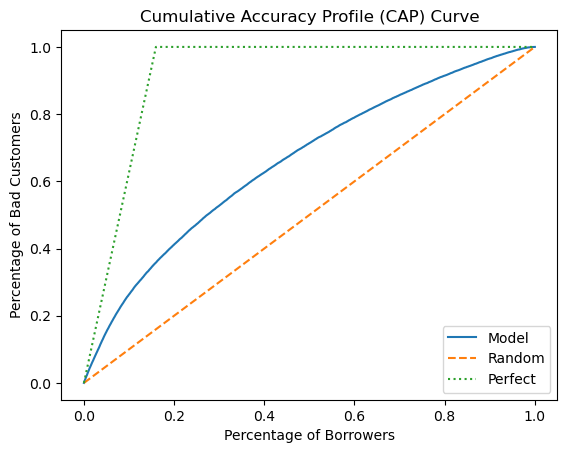

Accuracy Ratio: 0.3805


In [93]:
### Taken from Mitanshu CAP Curve
# Sort predicted probabilities in descending order
Probas_test = xgbc_hb1nc.predict_proba(X_hb1nc_sentilink_test)[:,1]
sorted_indices = np.argsort(Probas_test)[::-1]
sorted_probs = Probas_test[sorted_indices]
sorted_outcomes = y_hb1nc_sentilink_test.values[sorted_indices]
# Calculate cumulative numbers and percentages of bad customers
total_bad_customers = np.sum(sorted_outcomes)
cumulative_bad_customers = np.cumsum(sorted_outcomes)
cumulative_percent_bad = cumulative_bad_customers / total_bad_customers
# Create the CAP curve
total_borrowers = len(Probas_test)
cumulative_percent_borrowers = np.arange(1, total_borrowers + 1) / total_borrowers
# Plot the CAP curve
plt.plot(cumulative_percent_borrowers, cumulative_percent_bad, label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.plot([0, total_bad_customers / total_borrowers, 1], [0, 1, 1], linestyle=":", label="Perfect")
plt.xlabel("Percentage of Borrowers")
plt.ylabel("Percentage of Bad Customers")
plt.title("Cumulative Accuracy Profile (CAP) Curve")
plt.legend()
plt.show()
# Calculate the area under the CAP curve
area_model = np.trapz(cumulative_percent_bad, cumulative_percent_borrowers)
area_random = 0.5  # Area under the random model (diagonal line)
area_perfect = np.trapz([0, 1, 1], [0, total_bad_customers / total_borrowers, 1])
# Compute the accuracy ratio
accuracy_ratio = (area_model - area_random) / (area_perfect - area_random)
print(f"Accuracy Ratio: {accuracy_ratio:.4f}")

In [95]:
## Roie bucket function
def bucket(dfs, variable, num_buckets, target):
    res=dfs[{variable, target}]
    res['value_group'] = pd.cut(res[variable].astype(float), num_buckets, precision=0)
    res['value_group_q'] = pd.qcut(res[variable].astype(float), num_buckets, precision=0)


    print(pd.crosstab(res['value_group_q'], res[target]))
    print(pd.crosstab(res['value_group_q'], res[target], normalize = 'index'))
    pd.crosstab(res['value_group_q'], res[target]).to_clipboard()

In [152]:
X_hb1nc_sentilink_test = X_hb1nc_sentilink_test.drop(columns=['predicted_proba', 'decile', 'isF2PD'])

In [154]:
X_hb1nc_sentilink_test['predicted_proba'] = xgbc_hb1nc.predict_proba(X_hb1nc_sentilink_test)[:, 1]
X_hb1nc_sentilink_test['no_contact'] = y_hb1nc_sentilink_test

X_hb1nc_sentilink_test = X_hb1nc_sentilink_test.sort_values(by='predicted_proba', ascending=False)

X_hb1nc_sentilink_test['decile'] = pd.qcut(X_hb1nc_sentilink_test['predicted_proba'], 10)

lift_hb1nc = X_hb1nc_sentilink_test.groupby('decile').agg([
    'count',
    'sum'
]
                                                        )['no_contact'].sort_index(ascending=False)
lift_hb1nc.columns = ['Number of customers', 'Number of goods']
lift_hb1nc['Cumulative Goods'] = lift_hb1nc['Number of goods'].cumsum()

lift_hb1nc['Percent of Events']  = lift_hb1nc['Number of goods']/lift_hb1nc['Number of goods'].sum()*100
lift_hb1nc['Gain'] = lift_hb1nc['Percent of Events'].cumsum()
lift_hb1nc['Lift'] = lift_hb1nc['Gain']/np.array(range(10, 100+10, 10))
lift_hb1nc.head(10)

/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/2529896236.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lift_hb1nc = X_hb1nc_sentilink_test.groupby('decile').agg([


,Number of customers,Number of goods,Cumulative Goods,Percent of Events,Gain,Lift
decile,,,,,,
"(0.672, 0.947]",19558,8226,8226,26.351027,26.351027,2.635103
"(0.564, 0.672]",19558,4632,12858,14.838069,41.189096,2.059455
"(0.51, 0.564]",19558,3614,16472,11.577025,52.766121,1.758871
"(0.472, 0.51]",19557,3084,19556,9.879232,62.645353,1.566134
"(0.44, 0.472]",19558,2721,22277,8.716405,71.361758,1.427235
"(0.41, 0.44]",19558,2388,24665,7.649678,79.011436,1.316857
"(0.379, 0.41]",19557,2076,26741,6.650223,85.661659,1.223738
"(0.344, 0.379]",19558,1812,28553,5.804530,91.466188,1.143327
"(0.294, 0.344]",19558,1590,30143,5.093379,96.559567,1.072884


### 1.2.3 HB1 No Contact Feature Importances

In [350]:
## Added for the gain tables
X_hb1nc_sentilink_test = X_hb1nc_sentilink_test.drop(columns=['predicted_proba', 'decile', 'no_contact'])

#### From below, not using
thresholds = sort(xgbc_hb1nc.feature_importances_)
for thresh in thresholds:
    selection = SelectFromModel(xgbc_hb1nc, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_hb1nc_sentilink_train)
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_hb1nc_sentilink_train)
    select_X_test = selection.transform(X_hb1nc_sentilink_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_hb1nc_sentilink_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [356]:
feature_importances = pd.Series(xgbc_hb1nc.feature_importances_, index=X_hb1nc_sentilink_test.columns).sort_values(ascending=False)

In [358]:
top_20_importances = feature_importances.head(20).to_frame(name='Importance')
top_20_importances

,Importance
ip_non_mobile_over_160km_from_address_bin,0.161012
ip_is_high_risk_vpn_bin,0.135527
ip_min_distance_to_addresses_on_record_km,0.072000
phone_velocity_30d_cluster,0.029703
email_velocity_at_institution_30d_cluster,0.026123
address_min_distance_from_known_addresses_km,0.024221
ip_count_cluster,0.023920
applicant_oldest_address_yrs,0.023474
applicant_num_phones_cluster,0.021410
applicant_num_distinct_institutions_60d_cluster,0.020367


# 2. isOriginated: isF2PD

## 2.1 isF2PD

In [97]:
df_isOrig.columns.tolist()

['lead_sequence_id',
 'address_city_matches_records',
 'address_distance_from_most_recent_on_record_km',
 'address_history_yrs',
 'address_min_distance_from_known_addresses_km',
 'address_num_apps_cluster',
 'address_num_identities_w_address_120d_cluster',
 'address_num_identities_w_address_1y_cluster',
 'address_num_identities_w_address_30d_cluster',
 'address_num_identities_w_address_60d_cluster',
 'address_num_susp_phones',
 'address_num_very_susp_phones',
 'address_pct_linked_phones_w_state_mismatch',
 'address_ratio_distinct_identities_in_past_30d_cluster',
 'address_ssn_ssn5_abuse_in_zipcode',
 'applicant_email_history_never_seen_yrs',
 'applicant_has_bankruptcy_full_match',
 'applicant_has_bankruptcy_w_another_ssn',
 'applicant_has_fraud_victim_extended_alert',
 'applicant_has_itin_history',
 'applicant_history_best_matching_record_yrs',
 'applicant_history_delay_from_expected_start_yrs',
 'applicant_history_w_better_issuance_ssn_state_yrs_match',
 'applicant_history_w_better_ss

In [99]:
df_iso_sentilink = df_isOrig.drop(columns=['lead_sequence_id', 'decision', 'organization_id', 'isorigination', 'base_loan_id', 'Ever_30DPD_in_90',
                               'isFPD', 'decile', 'MK2rs', 'cfirs', 'cbbrs'])
df_iso_sentilink.shape

(75113, 264)

drop na isF2PD values

In [102]:
df_iso_sentilink = df_iso_sentilink.dropna(subset = ['isF2PD'])
df_iso_sentilink

,address_city_matches_records,address_distance_from_most_recent_on_record_km,address_history_yrs,address_min_distance_from_known_addresses_km,address_num_apps_cluster,address_num_identities_w_address_120d_cluster,address_num_identities_w_address_1y_cluster,address_num_identities_w_address_30d_cluster,address_num_identities_w_address_60d_cluster,address_num_susp_phones,...,ssn_address_state_mismatch_score,ssn_bogus,ssn_frac_in_ssn_window_w_history,ssn_may_belong_to_a_minor,ssn_num_identities_cluster,ssn_prop_in_window,ssn_random_but_matches_state,zipcode_first_3_matches_manifest,zipcode_matches_manifest,isF2PD
0,True,0.000000,1.125257,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.139211,False,NaN,False,1.0,NaN,NaN,True,True,0.0
1,True,5.387749,24.621492,0.0,12.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,False,NaN,False,2.0,NaN,NaN,True,True,0.0
2,True,0.000000,1.535934,0.0,17.0,0.0,1.0,0.0,0.0,1.0,...,0.045480,False,NaN,False,1.0,NaN,NaN,True,True,0.0
3,True,0.000000,2.620123,0.0,18.0,1.0,1.0,1.0,1.0,0.0,...,4.624782,False,NaN,False,4.0,NaN,NaN,True,True,0.0
4,True,0.000000,4.125941,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.033003,False,NaN,False,1.0,NaN,NaN,True,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,True,0.000000,NaN,0.0,49.0,NaN,NaN,NaN,NaN,0.0,...,0.000000,False,NaN,False,1.0,NaN,NaN,True,True,0.0
74996,False,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,0.0,...,0.140561,False,NaN,False,2.0,NaN,NaN,True,False,0.0
74997,True,0.000000,5.149897,0.0,49.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,False,NaN,False,3.0,NaN,NaN,True,True,0.0
74998,True,0.000000,0.739220,0.0,24.0,1.0,2.0,1.0,1.0,0.0,...,0.717703,False,NaN,False,1.0,NaN,NaN,True,True,0.0


In [104]:
cols_binary  = []
for c in df_iso_sentilink.columns[df_iso_sentilink.dtypes == 'object']:
    if df_iso_sentilink[c].nunique()<=2:
        print(c,df_iso_sentilink[c].unique())
        cols_binary.append(c)

address_city_matches_records [True False nan]
applicant_has_bankruptcy_full_match [False True nan]
applicant_has_bankruptcy_w_another_ssn [False True nan]
applicant_has_fraud_victim_extended_alert [False nan True]
applicant_has_itin_history [False True nan]
applicant_is_best_email_owner_by_history_length [nan True False]
applicant_is_best_email_owner_by_recency [nan False True]
applicant_is_best_email_owner_by_usage [nan True False]
applicant_is_best_phone_owner_by_history [True False nan]
applicant_is_best_phone_owner_by_recency [True False nan]
applicant_likely_has_better_ssn [nan False True]
applicant_possible_same_name_fraud [False True]
applicant_shares_address_history_w_email_owner [nan True False]
email_and_address_match_different_identity_cluster [False True]
email_begins_with_middle_initial [False True]
email_common_domain [True False]
email_common_mail_dot_com [False True]
email_contains_dob [False True]
email_contains_duplicate_digits [False True]
email_contains_firstname [T

In [106]:
print(df_iso_sentilink.shape)
df_iso_sentilink = true_false_to_numeric(df_iso_sentilink, cols_binary)
print(df_iso_sentilink.shape)

(73981, 264)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will 

(73981, 264)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()


In [108]:
X = df_iso_sentilink.drop(columns = ['isF2PD'])
y = df_iso_sentilink['isF2PD']

X_iso_sentilink_train, X_iso_sentilink_other, y_iso_sentilink_train, y_iso_sentilink_other = train_test_split(X, y, test_size=0.3, random_state=42)
X_iso_sentilink_vald, X_iso_sentilink_test, y_iso_sentilink_vald, y_iso_sentilink_test = train_test_split(X_iso_sentilink_other, y_iso_sentilink_other, test_size=0.5, random_state=42)

In [110]:
print(y_iso_sentilink_train.value_counts())
print(y_iso_sentilink_train.value_counts(normalize = True))

isF2PD
0.0    48902
1.0     2884
Name: count, dtype: int64
isF2PD
0.0    0.944309
1.0    0.055691
Name: proportion, dtype: float64


In [112]:
print(y_iso_sentilink_test.value_counts())
print(y_iso_sentilink_test.value_counts(normalize = True))

isF2PD
0.0    10433
1.0      665
Name: count, dtype: int64
isF2PD
0.0    0.940079
1.0    0.059921
Name: proportion, dtype: float64


In [114]:
model_iso_sentilink = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_iso_sentilink.fit(X_iso_sentilink_train, y_iso_sentilink_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:24:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [116]:
y_pred_iso_sentilink = model_iso_sentilink.predict(X_iso_sentilink_test)
y_pred_prob_iso_sentilink = model_iso_sentilink.predict_proba(X_iso_sentilink_test)[:, 1]
accuracy_iso_sentilink = accuracy_score(y_iso_sentilink_test, y_pred_iso_sentilink)
roc_auc_iso_sentilink = roc_auc_score(y_iso_sentilink_test, y_pred_prob_iso_sentilink)
precision, recall, thresholds = precision_recall_curve(y_iso_sentilink_test, y_pred_prob_iso_sentilink, pos_label=1)

print('AUC PR score for isOrig NotRecovered FP sentilink: ' + str(metrics.auc(recall, precision)))
print(f"Accuracy score for isOrig NotRecovered FP sentilink: {accuracy_iso_sentilink}")
print(f"ROC AUC Score for isOrig NotRecovered FP sentilink: {roc_auc_iso_sentilink}")

AUC PR score for isOrig NotRecovered FP sentilink: 0.1033944381058124
Accuracy score for isOrig NotRecovered FP sentilink: 0.9405298251937286
ROC AUC Score for isOrig NotRecovered FP sentilink: 0.5754993013060783


 - AUC PR from ~0.057

In [118]:
scale_pos_weight = y_iso_sentilink_train.value_counts()[0] / y_iso_sentilink_train.value_counts()[1]
round(scale_pos_weight,2)

16.96

In [122]:
eval_set = [(X_iso_sentilink_train, y_iso_sentilink_train), (X_iso_sentilink_vald, y_iso_sentilink_vald)]

def train_model(n_estimators, subsample, reg_lambda, reg_alpha, min_child_weight, max_depth, learning_rate, colsample_bytree):
    params = {
        'n_estimators': int(round(n_estimators)),
        'subsample': subsample,
        'reg_lambda': int(round(reg_lambda)),
        'reg_alpha': int(round(reg_alpha)),
        'min_child_weight': round(min_child_weight),
        'max_depth': int(round(max_depth)),
        'learning_rate': learning_rate,
        'colsample_bytree': colsample_bytree
    }
    xgbc_isOF2PD = XGBClassifier(n_jobs = -1, eval_metric = ['error','aucpr'], early_stopping_rounds=20, objective='binary:logistic', **params, scale_pos_weight = scale_pos_weight)
    xgbc_isOF2PD.fit(X_iso_sentilink_train, y_iso_sentilink_train, eval_set=eval_set, verbose=50)
    return xgbc_isOF2PD.evals_result()['validation_1']['aucpr'][-1]

xgb_param_grid = {
    'n_estimators' : (50, 201),
    'subsample': (0.7, 0.95),
    'reg_lambda': (1, 60),
    'reg_alpha': (1, 20), 
    'min_child_weight':(10, 51),
    'max_depth' : (2, 3),
    'learning_rate' : (0.01, 0.2),
    'colsample_bytree': (0.6, 0.95)
}

optimizer = BayesianOptimization(
    f=train_model,
    pbounds=xgb_param_grid,
    #random_state=1,
)
optimizer.maximize(init_points=2, n_iter=23)
 
print(optimizer.max)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[0]	validation_0-error:0.43630	validation_0-aucpr:0.07229	validation_1-error:0.44246	validation_1-aucpr:0.06528
[50]	validation_0-error:0.34096	validation_0-aucpr:0.14322	validation_1-error:0.35640	validation_1-aucpr:0.08814
[90]	validation_0-error:0.31424	validation_0-aucpr:0.17447	validation_1-error:0.33631	validation_1-aucpr:0.08901
| 1         | 0.08895   | 0.7086    | 0.1923    | 2.64      | 15.15     | 172.8     | 10.06     | 37.29     | 0.8695    |
[0]	validation_0-error:0.49247	validation_0-aucpr:0.07555	validation_1-error:0.50149	validation_1-aucpr:0.06768
[50]	validation_0-error:0.35457	validation_0-aucpr:0.13550	validation_1-error:0.37019	validation_1-aucpr:0.08777
[100]	validation_0-error:0.32499	validation_0-aucpr:0.16599	validation_

In [126]:
xgbc_isOF2PD.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.79,
 'device': None,
 'eval_metric': ['error', 'aucpr'],
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.15,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': 44.43,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 19.33,
 'reg_lambda': 11.39,
 'sampling_method': None,
 'scale_pos_weight': 16.95631067961165,
 'subsample': 0.78,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [124]:
print("Train full model with the best hyperparameter set...")

eval_set = [(X_iso_sentilink_train, y_iso_sentilink_train), (X_iso_sentilink_vald, y_iso_sentilink_vald)]
xgbc_isOF2PD = XGBClassifier(n_estimators = int(optimizer.max['params']['n_estimators']), 
                         n_jobs = -1, 
                         subsample = round(optimizer.max['params']['subsample'],2), 
                         reg_lambda = round(optimizer.max['params']['reg_lambda'],2), 
                         reg_alpha = round(optimizer.max['params']['reg_alpha'],2),
                         min_child_weight = round(optimizer.max['params']['min_child_weight'],2),
                         max_depth = int(optimizer.max['params']['max_depth']), 
                         learning_rate= round(optimizer.max['params']['learning_rate'],2),  
                         colsample_bytree = round(optimizer.max['params']['colsample_bytree'],2), 
                         scale_pos_weight = scale_pos_weight,
                         objective='binary:logistic',
                         eval_metric = ['error','aucpr'],
                         early_stopping_rounds=20
                        )
 
 
xgbc_isOF2PD.fit(X_iso_sentilink_train, y_iso_sentilink_train, eval_set=eval_set, verbose=50)
 
 
#AUCs
simple_split_pred_train = xgbc_isOF2PD.predict_proba(X_iso_sentilink_train)
fpr, tpr, thresholds = metrics.roc_curve(y_iso_sentilink_train, simple_split_pred_train[:,1], pos_label=1)
print('AUC full train set: ' + str(metrics.auc(fpr, tpr)))
precision, recall, thresholds = precision_recall_curve(y_iso_sentilink_train, simple_split_pred_train[:,1], pos_label=1)
print('AUC PR full train set: ' + str(metrics.auc(recall, precision)))
 
simple_split_pred_vald = xgbc_isOF2PD.predict_proba(X_iso_sentilink_vald)
fpr, tpr, thresholds = metrics.roc_curve(y_iso_sentilink_vald, simple_split_pred_vald[:,1], pos_label=1)
print('AUC full vald set: ' + str(metrics.auc(fpr, tpr)))
precision, recall, thresholds = precision_recall_curve(y_iso_sentilink_vald, simple_split_pred_vald[:,1], pos_label=1)
print('AUC PR full vald set: ' + str(metrics.auc(recall, precision)))

binary_threshold_eval = thresholds[np.argmax(tpr-fpr)]
print('Threshold that generates max(tpr-fpr) for test population: ' + str(binary_threshold_eval))
binary_pred_eval = np.where(simple_split_pred_vald[:,1] >= binary_threshold_eval, 1, 0)
display(pd.crosstab(binary_pred_eval, np.array(y_iso_sentilink_vald.to_list())))
print('Full model predicted accuracy: ' + str(accuracy_score(binary_pred_eval, y_iso_sentilink_vald)))

Train full model with the best hyperparameter set...
[0]	validation_0-error:0.50585	validation_0-aucpr:0.06974	validation_1-error:0.51293	validation_1-aucpr:0.06774
[50]	validation_0-error:0.37833	validation_0-aucpr:0.11202	validation_1-error:0.39227	validation_1-aucpr:0.08776
[100]	validation_0-error:0.36158	validation_0-aucpr:0.12603	validation_1-error:0.37614	validation_1-aucpr:0.09255
[118]	validation_0-error:0.35774	validation_0-aucpr:0.12830	validation_1-error:0.37226	validation_1-aucpr:0.09180
AUC full train set: 0.6798741309219816
AUC PR full train set: 0.12584240112498263
AUC full vald set: 0.6049962123216925
AUC PR full vald set: 0.09274304010440901
Threshold that generates max(tpr-fpr) for test population: 0.34326917


col_0,0.0,1.0
row_0,,
0,809,20
1,9702,566


Full model predicted accuracy: 0.12390736235018474


## 2.2 isOrigination isF2PD Results

In [266]:
X_iso_sentilink_test = X_iso_sentilink_test.drop(columns=['predicted_proba', 'decile', 'isF2PD'])

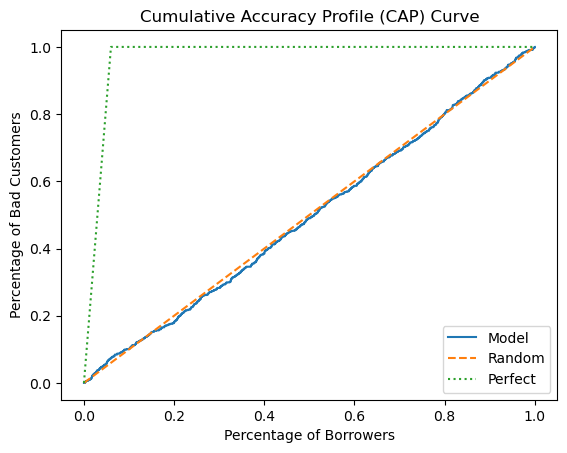

Accuracy Ratio: -0.0109


In [268]:
# Sort predicted probabilities in descending order
Probas_test = xgbc_isOF2PD.predict_proba(X_iso_sentilink_test)[:,1]
sorted_indices = np.argsort(Probas_test)[::-1]
sorted_probs = Probas_test[sorted_indices]
sorted_outcomes = y_iso_sentilink_test.values[sorted_indices]
# Calculate cumulative numbers and percentages of bad customers
total_bad_customers = np.sum(sorted_outcomes)
cumulative_bad_customers = np.cumsum(sorted_outcomes)
cumulative_percent_bad = cumulative_bad_customers / total_bad_customers
# Create the CAP curve
total_borrowers = len(Probas_test)
cumulative_percent_borrowers = np.arange(1, total_borrowers + 1) / total_borrowers
# Plot the CAP curve
plt.plot(cumulative_percent_borrowers, cumulative_percent_bad, label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.plot([0, total_bad_customers / total_borrowers, 1], [0, 1, 1], linestyle=":", label="Perfect")
plt.xlabel("Percentage of Borrowers")
plt.ylabel("Percentage of Bad Customers")
plt.title("Cumulative Accuracy Profile (CAP) Curve")
plt.legend()
plt.show()
# Calculate the area under the CAP curve
area_model = np.trapz(cumulative_percent_bad, cumulative_percent_borrowers)
area_random = 0.5  # Area under the random model (diagonal line)
area_perfect = np.trapz([0, 1, 1], [0, total_bad_customers / total_borrowers, 1])
# Compute the accuracy ratio
accuracy_ratio = (area_model - area_random) / (area_perfect - area_random)
print(f"Accuracy Ratio: {accuracy_ratio:.4f}")

In [128]:
X_iso_sentilink_test['predicted_proba'] = xgbc_isOF2PD.predict_proba(X_iso_sentilink_test)[:, 1]
X_iso_sentilink_test['isF2PD'] = y_iso_sentilink_test
X_iso_sentilink_test.head()

,address_city_matches_records_bin,address_distance_from_most_recent_on_record_km,address_history_yrs,address_min_distance_from_known_addresses_km,address_num_apps_cluster,address_num_identities_w_address_120d_cluster,address_num_identities_w_address_1y_cluster,address_num_identities_w_address_30d_cluster,address_num_identities_w_address_60d_cluster,address_num_susp_phones,...,ssn_bogus_bin,ssn_frac_in_ssn_window_w_history,ssn_may_belong_to_a_minor_bin,ssn_num_identities_cluster,ssn_prop_in_window,ssn_random_but_matches_state_bin,zipcode_first_3_matches_manifest_bin,zipcode_matches_manifest_bin,predicted_proba,isF2PD
9836,1.0,14.893574,15.173169,0.000000,49.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,0.0,1.0,NaN,NaN,1,1.0,0.478045,0.0
32413,1.0,0.000000,NaN,0.000000,49.0,NaN,NaN,NaN,NaN,0.0,...,0,NaN,0.0,2.0,NaN,NaN,1,1.0,0.542353,0.0
62351,1.0,0.000000,1.169062,0.000000,11.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,0.0,4.0,NaN,NaN,1,1.0,0.510868,0.0
29534,1.0,16.691226,9.919233,0.000000,51.0,2.0,3.0,0.0,2.0,0.0,...,0,NaN,0.0,5.0,NaN,NaN,1,1.0,0.543268,0.0
2210,0.0,736.005236,NaN,706.378438,2.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,0.0,3.0,NaN,NaN,0,0.0,0.382328,0.0


In [130]:
X_iso_sentilink_test = X_iso_sentilink_test.sort_values(by='predicted_proba', ascending=False)
X_iso_sentilink_test.head()

,address_city_matches_records_bin,address_distance_from_most_recent_on_record_km,address_history_yrs,address_min_distance_from_known_addresses_km,address_num_apps_cluster,address_num_identities_w_address_120d_cluster,address_num_identities_w_address_1y_cluster,address_num_identities_w_address_30d_cluster,address_num_identities_w_address_60d_cluster,address_num_susp_phones,...,ssn_bogus_bin,ssn_frac_in_ssn_window_w_history,ssn_may_belong_to_a_minor_bin,ssn_num_identities_cluster,ssn_prop_in_window,ssn_random_but_matches_state_bin,zipcode_first_3_matches_manifest_bin,zipcode_matches_manifest_bin,predicted_proba,isF2PD
37090,1.0,21.699534,32.030116,0.000000,12.0,0.0,1.0,0.0,0.0,0.0,...,0,NaN,0.0,1.0,NaN,NaN,1,1.0,0.867926,1.0
39463,1.0,13.766466,18.436687,0.000000,23.0,1.0,2.0,0.0,1.0,0.0,...,0,NaN,0.0,2.0,NaN,NaN,1,1.0,0.859765,1.0
72039,1.0,25.804829,NaN,1.107045,50.0,NaN,NaN,NaN,NaN,0.0,...,0,NaN,0.0,1.0,NaN,NaN,1,1.0,0.843473,0.0
39885,1.0,114.264079,17.524983,0.000000,24.0,1.0,1.0,1.0,1.0,0.0,...,0,NaN,0.0,2.0,NaN,NaN,1,1.0,0.833402,1.0
41511,1.0,32.689373,37.653662,0.309552,2.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,0.0,2.0,NaN,NaN,1,1.0,0.783543,1.0


In [134]:
X_iso_sentilink_test['decile'] = pd.qcut(X_iso_sentilink_test['predicted_proba'], 10)
X_iso_sentilink_test.head()

,address_city_matches_records_bin,address_distance_from_most_recent_on_record_km,address_history_yrs,address_min_distance_from_known_addresses_km,address_num_apps_cluster,address_num_identities_w_address_120d_cluster,address_num_identities_w_address_1y_cluster,address_num_identities_w_address_30d_cluster,address_num_identities_w_address_60d_cluster,address_num_susp_phones,...,ssn_frac_in_ssn_window_w_history,ssn_may_belong_to_a_minor_bin,ssn_num_identities_cluster,ssn_prop_in_window,ssn_random_but_matches_state_bin,zipcode_first_3_matches_manifest_bin,zipcode_matches_manifest_bin,predicted_proba,isF2PD,decile
37090,1.0,21.699534,32.030116,0.000000,12.0,0.0,1.0,0.0,0.0,0.0,...,NaN,0.0,1.0,NaN,NaN,1,1.0,0.867926,1.0,"(0.593, 0.868]"
39463,1.0,13.766466,18.436687,0.000000,23.0,1.0,2.0,0.0,1.0,0.0,...,NaN,0.0,2.0,NaN,NaN,1,1.0,0.859765,1.0,"(0.593, 0.868]"
72039,1.0,25.804829,NaN,1.107045,50.0,NaN,NaN,NaN,NaN,0.0,...,NaN,0.0,1.0,NaN,NaN,1,1.0,0.843473,0.0,"(0.593, 0.868]"
39885,1.0,114.264079,17.524983,0.000000,24.0,1.0,1.0,1.0,1.0,0.0,...,NaN,0.0,2.0,NaN,NaN,1,1.0,0.833402,1.0,"(0.593, 0.868]"
41511,1.0,32.689373,37.653662,0.309552,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,2.0,NaN,NaN,1,1.0,0.783543,1.0,"(0.593, 0.868]"


In [138]:
lift_isF2PD = X_iso_sentilink_test.groupby('decile').agg([
    'count',
    'sum'
]
                                                        )['isF2PD'].sort_index(ascending=False)
lift_isF2PD.columns = ['Number of customers', 'Number of goods']
lift_isF2PD['Cumulative Goods'] = lift_isF2PD['Number of goods'].cumsum()

lift_isF2PD['Percent of Events']  = lift_isF2PD['Number of goods']/lift_isF2PD['Number of goods'].sum()*100
lift_isF2PD['Gain'] = lift_isF2PD['Percent of Events'].cumsum()
lift_isF2PD['Lift'] = lift_isF2PD['Gain']/np.array(range(10, 100+10, 10))
lift_isF2PD.head(10)

/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/1752403358.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lift_isF2PD = X_iso_sentilink_test.groupby('decile').agg([


,Number of customers,Number of goods,Cumulative Goods,Percent of Events,Gain,Lift
decile,,,,,,
"(0.593, 0.868]",1110,120.0,120.0,18.045113,18.045113,1.804511
"(0.55, 0.593]",1110,88.0,208.0,13.233083,31.278195,1.563910
"(0.52, 0.55]",1110,79.0,287.0,11.879699,43.157895,1.438596
"(0.495, 0.52]",1109,86.0,373.0,12.932331,56.090226,1.402256
"(0.47, 0.495]",1110,65.0,438.0,9.774436,65.864662,1.317293
"(0.447, 0.47]",1110,46.0,484.0,6.917293,72.781955,1.213033
"(0.423, 0.447]",1109,51.0,535.0,7.669173,80.451128,1.149302
"(0.393, 0.423]",1110,52.0,587.0,7.819549,88.270677,1.103383
"(0.353, 0.393]",1110,38.0,625.0,5.714286,93.984962,1.044277


# 3. Scores

## 3.1 Data

In [181]:
## Basically the same df as the models but keeping the scores
df_hb1_nocont_score = df_hb1.drop(columns=['lead_sequence_id', 'decision', 'isorigination', 'base_loan_id', 'Ever_30DPD_in_90',
                               'isFPD', 'decile', 'withdrawn_reason'])
df_hb1_nocont_score.shape
# 'MK2rs', 'cfirs', 'cbbrs'

(1303853, 268)

In [183]:
df_iso_score = df_isOrig.drop(columns=['lead_sequence_id', 'decision', 'isorigination', 'base_loan_id', 'Ever_30DPD_in_90',
                               'isFPD', 'decile'])
df_iso_score.shape

(75113, 268)

In [185]:
def find_max_min_application_id(df, column_name):
    if column_name in df.columns:
        max_value = df[column_name].max()
        min_value = df[column_name].min()
        return max_value, min_value
    else:
        return None, None
    
max_id, min_id = find_max_min_application_id(df_hb1, 'lead_sequence_id')
print(f"Max lsid: {max_id}")
print(f"Min lsid: {min_id}")

Max lsid: 2617618300
Min lsid: 2562747680


In [187]:
max_id, min_id = find_max_min_application_id(df_isOrig, 'lead_sequence_id')
print(f"Max lsid: {max_id}")
print(f"Min lsid: {min_id}")

Max lsid: 2617618300
Min lsid: 2562763313


cfi as cfirs, cbb2 as cbbrs, march2023 as MK2rs
compare just using the scores to predict defaults (or a different column) to using the sentilink data as well as the scores
phone to name - contact??
Yet to do:
   - match to ekata feature names and see similarity / new features that are offered

In [189]:
scores = ['MK2rs', 'cbbrs', 'cfirs']

## 3.2 isOrig // isF2PD

### 3.2.1 Data

In [193]:
df_iso_score[scores].isnull().sum()

MK2rs    4268
cbbrs    3935
cfirs     338
dtype: int64

In [195]:
df_iso_score['organization_id'].value_counts()

organization_id
2.0    32551
3.0    18317
4.0    17324
1.0     6921
Name: count, dtype: int64

In [216]:
df_iso_score = df_iso_score.dropna(subset = ['isF2PD'])
df_iso_score

,address_city_matches_records,address_distance_from_most_recent_on_record_km,address_history_yrs,address_min_distance_from_known_addresses_km,address_num_apps_cluster,address_num_identities_w_address_120d_cluster,address_num_identities_w_address_1y_cluster,address_num_identities_w_address_30d_cluster,address_num_identities_w_address_60d_cluster,address_num_susp_phones,...,ssn_num_identities_cluster,ssn_prop_in_window,ssn_random_but_matches_state,zipcode_first_3_matches_manifest,zipcode_matches_manifest,organization_id,MK2rs,cbbrs,cfirs,isF2PD
0,True,0.000000,1.125257,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,1.0,NaN,NaN,True,True,4.0,807.0,729.0,905.0,0.0
1,True,5.387749,24.621492,0.0,12.0,0.0,1.0,0.0,0.0,0.0,...,2.0,NaN,NaN,True,True,2.0,565.0,805.0,772.0,0.0
2,True,0.000000,1.535934,0.0,17.0,0.0,1.0,0.0,0.0,1.0,...,1.0,NaN,NaN,True,True,2.0,495.0,792.0,871.0,0.0
3,True,0.000000,2.620123,0.0,18.0,1.0,1.0,1.0,1.0,0.0,...,4.0,NaN,NaN,True,True,4.0,806.0,862.0,939.0,0.0
4,True,0.000000,4.125941,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1.0,NaN,NaN,True,True,1.0,NaN,NaN,636.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,True,0.000000,NaN,0.0,49.0,NaN,NaN,NaN,NaN,0.0,...,1.0,NaN,NaN,True,True,4.0,454.0,709.0,794.0,0.0
74996,False,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,0.0,...,2.0,NaN,NaN,True,False,2.0,472.0,778.0,806.0,0.0
74997,True,0.000000,5.149897,0.0,49.0,0.0,0.0,0.0,0.0,0.0,...,3.0,NaN,NaN,True,True,2.0,472.0,795.0,795.0,0.0
74998,True,0.000000,0.739220,0.0,24.0,1.0,2.0,1.0,1.0,0.0,...,1.0,NaN,NaN,True,True,3.0,405.0,684.0,823.0,0.0


In [218]:
## Make new dfs for each score as they are not applied to every org
df_iso_mk2rs = df_iso_score[df_iso_score['organization_id'].isin([2, 3, 4]) & df_iso_score['MK2rs'].notna()]
df_iso_cfi = df_iso_score[df_iso_score['cfirs'].notna()]
df_iso_cbb = df_iso_score[df_iso_score['cbbrs'].notna()]
print(df_iso_mk2rs.shape, df_iso_cfi.shape, df_iso_cbb.shape)

(65590, 268) (73646, 268) (70066, 268)


### 3.2.2 MK2rs

Same modeling process as above

In [221]:
cols_binary  = []
for c in df_iso_mk2rs.columns[df_iso_mk2rs.dtypes == 'object']:
    if df_iso_mk2rs[c].nunique()<=2:
        print(c,df_iso_mk2rs[c].unique())
        cols_binary.append(c)

address_city_matches_records [True False nan]
applicant_has_bankruptcy_full_match [False True nan]
applicant_has_bankruptcy_w_another_ssn [False True nan]
applicant_has_fraud_victim_extended_alert [False nan True]
applicant_has_itin_history [False True nan]
applicant_is_best_email_owner_by_history_length [nan True False]
applicant_is_best_email_owner_by_recency [nan False True]
applicant_is_best_email_owner_by_usage [nan True False]
applicant_is_best_phone_owner_by_history [True False nan]
applicant_is_best_phone_owner_by_recency [True nan False]
applicant_likely_has_better_ssn [nan False True]
applicant_possible_same_name_fraud [False True]
applicant_shares_address_history_w_email_owner [nan True False]
email_and_address_match_different_identity_cluster [False True]
email_begins_with_middle_initial [False True]
email_common_domain [True False]
email_common_mail_dot_com [False True]
email_contains_dob [False True]
email_contains_duplicate_digits [False True]
email_contains_firstname [T

In [223]:
print(df_iso_mk2rs.shape)
df_iso_mk2rs = true_false_to_numeric(df_iso_mk2rs, cols_binary)
print(df_iso_mk2rs.shape)

(65590, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.lower().copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

(65590, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {col: col+'_bin'}, inplace = True)


In [225]:
X = df_iso_mk2rs['MK2rs']
y = df_iso_mk2rs['isF2PD']

X_iso_mk2rs_train, X_iso_mk2rs_other, y_iso_mk2rs_train, y_iso_mk2rs_other = train_test_split(X, y, test_size=0.3, random_state=42)
X_iso_mk2rs_vald, X_iso_mk2rs_test, y_iso_mk2rs_vald, y_iso_mk2rs_test = train_test_split(X_iso_mk2rs_other, y_iso_mk2rs_other, test_size=0.5, random_state=42)

In [227]:
model_iso_mk2rs = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_iso_mk2rs.fit(X_iso_mk2rs_train, y_iso_mk2rs_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:45:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [231]:
df_iso_mk2rs['isF2PD'].value_counts(normalize=True)

isF2PD
0.0    0.949947
1.0    0.050053
Name: proportion, dtype: float64

In [229]:
y_pred_iso_mk2rs = model_iso_mk2rs.predict(X_iso_mk2rs_test)
y_pred_prob_iso_mk2rs = model_iso_mk2rs.predict_proba(X_iso_mk2rs_test)[:, 1]
accuracy_iso_mk2rs = accuracy_score(y_iso_mk2rs_test, y_pred_iso_mk2rs)
roc_auc_iso_mk2rs = roc_auc_score(y_iso_mk2rs_test, y_pred_prob_iso_mk2rs)
precision, recall, thresholds = precision_recall_curve(y_iso_mk2rs_test, y_pred_prob_iso_mk2rs, pos_label=1)

print('AUC PR score for mk2rs sentilink: ' + str(metrics.auc(recall, precision)))
print(f"Accuracy score for mk2rs sentilink: {accuracy_iso_mk2rs}")
print(f"ROC AUC Score for mk2rs sentilink: {roc_auc_iso_mk2rs}")

AUC PR score for mk2rs sentilink: 0.07552377095795157
Accuracy score for mk2rs sentilink: 0.9516210997052545
ROC AUC Score for mk2rs sentilink: 0.6524994009138421


 - AUC PR up from 0.050053 (minor lift)

### 3.2.3 cfirs

In [238]:
cols_binary  = []
for c in df_iso_cfi.columns[df_iso_cfi.dtypes == 'object']:
    if df_iso_cfi[c].nunique()<=2:
        print(c,df_iso_cfi[c].unique())
        cols_binary.append(c)

address_city_matches_records [True False nan]
applicant_has_bankruptcy_full_match [False True nan]
applicant_has_bankruptcy_w_another_ssn [False True nan]
applicant_has_fraud_victim_extended_alert [False nan True]
applicant_has_itin_history [False True nan]
applicant_is_best_email_owner_by_history_length [nan True False]
applicant_is_best_email_owner_by_recency [nan False True]
applicant_is_best_email_owner_by_usage [nan True False]
applicant_is_best_phone_owner_by_history [True False nan]
applicant_is_best_phone_owner_by_recency [True False nan]
applicant_likely_has_better_ssn [nan False True]
applicant_possible_same_name_fraud [False True]
applicant_shares_address_history_w_email_owner [nan True False]
email_and_address_match_different_identity_cluster [False True]
email_begins_with_middle_initial [False True]
email_common_domain [True False]
email_common_mail_dot_com [False True]
email_contains_dob [False True]
email_contains_duplicate_digits [False True]
email_contains_firstname [T

In [240]:
print(df_iso_cfi.shape)
df_iso_cfi = true_false_to_numeric(df_iso_cfi, cols_binary)
print(df_iso_cfi.shape)

(73646, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.lower().copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

(73646, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:14: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [242]:
X = df_iso_cfi['cfirs']
y = df_iso_cfi['isF2PD']

X_iso_cfi_train, X_iso_cfi_other, y_iso_cfi_train, y_iso_cfi_other = train_test_split(X, y, test_size=0.3, random_state=42)
X_iso_cfi_vald, X_iso_cfi_test, y_iso_cfi_vald, y_iso_cfi_test = train_test_split(X_iso_cfi_other, y_iso_cfi_other, test_size=0.5, random_state=42)

In [244]:
model_iso_cfi = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_iso_cfi.fit(X_iso_cfi_train, y_iso_cfi_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [246]:
df_iso_cfi['isF2PD'].value_counts(normalize=True)

isF2PD
0.0    0.94403
1.0    0.05597
Name: proportion, dtype: float64

In [248]:
y_pred_iso_cfi = model_iso_cfi.predict(X_iso_cfi_test)
y_pred_prob_iso_cfi = model_iso_cfi.predict_proba(X_iso_cfi_test)[:, 1]
accuracy_iso_cfi = accuracy_score(y_iso_cfi_test, y_pred_iso_cfi)
roc_auc_iso_cfi = roc_auc_score(y_iso_cfi_test, y_pred_prob_iso_cfi)
precision, recall, thresholds = precision_recall_curve(y_iso_cfi_test, y_pred_prob_iso_cfi, pos_label=1)

print('AUC PR score for mk2rs sentilink: ' + str(metrics.auc(recall, precision)))
print(f"Accuracy score for mk2rs sentilink: {accuracy_iso_cfi}")
print(f"ROC AUC Score for mk2rs sentilink: {roc_auc_iso_cfi}")

AUC PR score for mk2rs sentilink: 0.08568425953021878
Accuracy score for mk2rs sentilink: 0.9442382547297908
ROC AUC Score for mk2rs sentilink: 0.6028303495948016


 - AUC PR up from 0.05597

### 3.2.4 cbbrs

In [252]:
cols_binary  = []
for c in df_iso_cbb.columns[df_iso_cbb.dtypes == 'object']:
    if df_iso_cbb[c].nunique()<=2:
        print(c,df_iso_cbb[c].unique())
        cols_binary.append(c)

address_city_matches_records [True False nan]
applicant_has_bankruptcy_full_match [False True nan]
applicant_has_bankruptcy_w_another_ssn [False True nan]
applicant_has_fraud_victim_extended_alert [False nan True]
applicant_has_itin_history [False True nan]
applicant_is_best_email_owner_by_history_length [nan True False]
applicant_is_best_email_owner_by_recency [nan False True]
applicant_is_best_email_owner_by_usage [nan True False]
applicant_is_best_phone_owner_by_history [True False nan]
applicant_is_best_phone_owner_by_recency [True False nan]
applicant_likely_has_better_ssn [nan False True]
applicant_possible_same_name_fraud [False True]
applicant_shares_address_history_w_email_owner [nan True False]
email_and_address_match_different_identity_cluster [False True]
email_begins_with_middle_initial [False True]
email_common_domain [True False]
email_common_mail_dot_com [False True]
email_contains_dob [False True]
email_contains_duplicate_digits [False True]
email_contains_firstname [T

In [254]:
print(df_iso_cbb.shape)
df_iso_cbb = true_false_to_numeric(df_iso_cbb, cols_binary)
print(df_iso_cbb.shape)

(70066, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.lower().copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

(70066, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:14: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [256]:
X = df_iso_cbb['cbbrs']
y = df_iso_cbb['isF2PD']

X_iso_cbb_train, X_iso_cbb_other, y_iso_cbb_train, y_iso_cbb_other = train_test_split(X, y, test_size=0.3, random_state=42)
X_iso_cbb_vald, X_iso_cbb_test, y_iso_cbb_vald, y_iso_cbb_test = train_test_split(X_iso_cbb_other, y_iso_cbb_other, test_size=0.5, random_state=42)

In [258]:
model_iso_cbb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_iso_cbb.fit(X_iso_cbb_train, y_iso_cbb_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:05:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [260]:
df_iso_cbb['isF2PD'].value_counts(normalize=True)

isF2PD
0.0    0.946907
1.0    0.053093
Name: proportion, dtype: float64

In [262]:
y_pred_iso_cbb = model_iso_cbb.predict(X_iso_cbb_test)
y_pred_prob_iso_cbb = model_iso_cbb.predict_proba(X_iso_cbb_test)[:, 1]
accuracy_iso_cbb = accuracy_score(y_iso_cbb_test, y_pred_iso_cbb)
roc_auc_iso_cbb = roc_auc_score(y_iso_cbb_test, y_pred_prob_iso_cbb)
precision, recall, thresholds = precision_recall_curve(y_iso_cbb_test, y_pred_prob_iso_cbb, pos_label=1)

print('AUC PR score for mk2rs sentilink: ' + str(metrics.auc(recall, precision)))
print(f"Accuracy score for mk2rs sentilink: {accuracy_iso_cbb}")
print(f"ROC AUC Score for mk2rs sentilink: {roc_auc_iso_cbb}")

AUC PR score for mk2rs sentilink: 0.0702809950715027
Accuracy score for mk2rs sentilink: 0.9488106565176023
ROC AUC Score for mk2rs sentilink: 0.5507705031336814


 - up from 0.053093

## 3.3 HB1accept // no_contact

### 3.3.1 Data

In [290]:
df_hb1_nocont_score[scores].isnull().sum()

MK2rs      79571
cbbrs    1067843
cfirs      17273
dtype: int64

In [292]:
df_hb1_nocont_score['organization_id'].value_counts()

organization_id
2.0    546213
3.0    432393
4.0    208368
1.0    116879
Name: count, dtype: int64

In [296]:
df_hb1_nocont_score = df_hb1_nocont_score.dropna(subset = ['no_contact'])
df_hb1_nocont_score

,address_city_matches_records,address_distance_from_most_recent_on_record_km,address_history_yrs,address_min_distance_from_known_addresses_km,address_num_apps_cluster,address_num_identities_w_address_120d_cluster,address_num_identities_w_address_1y_cluster,address_num_identities_w_address_30d_cluster,address_num_identities_w_address_60d_cluster,address_num_susp_phones,...,ssn_num_identities_cluster,ssn_prop_in_window,ssn_random_but_matches_state,zipcode_first_3_matches_manifest,zipcode_matches_manifest,organization_id,MK2rs,cbbrs,cfirs,no_contact
0,True,26.392402,NaN,4.046947,2.0,0.0,1.0,0.0,0.0,0.0,...,1.0,NaN,NaN,True,True,1.0,NaN,NaN,821.0,0
1,True,0.000000,8.125941,0.000000,37.0,0.0,0.0,0.0,0.0,2.0,...,2.0,NaN,NaN,True,True,2.0,848.0,804.0,824.0,0
2,True,0.000000,1.125257,0.000000,5.0,0.0,0.0,0.0,0.0,0.0,...,1.0,NaN,NaN,True,True,4.0,807.0,729.0,905.0,1
3,True,0.000000,NaN,0.000000,2.0,NaN,NaN,NaN,NaN,0.0,...,2.0,NaN,NaN,True,True,4.0,394.0,NaN,722.0,1
4,True,0.000000,0.292950,0.000000,17.0,2.0,3.0,1.0,1.0,0.0,...,4.0,NaN,NaN,True,True,4.0,504.0,NaN,818.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303848,True,0.000000,1.325120,0.000000,17.0,0.0,1.0,0.0,0.0,1.0,...,4.0,0.073171,False,True,True,3.0,628.0,NaN,765.0,1
1303849,True,135.671603,21.325120,0.000000,10.0,0.0,0.0,0.0,0.0,0.0,...,3.0,NaN,NaN,True,True,2.0,754.0,NaN,902.0,1
1303850,True,0.000000,1.659138,0.000000,9.0,0.0,0.0,0.0,0.0,0.0,...,4.0,NaN,NaN,True,True,2.0,793.0,NaN,931.0,1
1303851,True,75.403500,6.324435,0.000000,12.0,0.0,2.0,0.0,0.0,0.0,...,1.0,NaN,NaN,True,True,2.0,342.0,NaN,765.0,1


In [298]:
df_hb1nc_mk2rs = df_hb1_nocont_score[df_hb1_nocont_score['organization_id'].isin([2, 3, 4]) & df_hb1_nocont_score['MK2rs'].notna()]
df_hb1nc_cfi = df_hb1_nocont_score[df_hb1_nocont_score['cfirs'].notna()]
df_hb1nc_cbb = df_hb1_nocont_score[df_hb1_nocont_score['cbbrs'].notna()]
print(df_hb1nc_mk2rs.shape, df_hb1nc_cfi.shape, df_hb1nc_cbb.shape)

(1154863, 268) (1286580, 268) (236010, 268)


### 3.3.2 MK2rs

In [300]:
cols_binary  = []
for c in df_hb1nc_mk2rs.columns[df_hb1nc_mk2rs.dtypes == 'object']:
    if df_hb1nc_mk2rs[c].nunique()<=2:
        print(c,df_hb1nc_mk2rs[c].unique())
        cols_binary.append(c)

address_city_matches_records [True False nan]
applicant_has_bankruptcy_full_match [False True nan]
applicant_has_bankruptcy_w_another_ssn [False True nan]
applicant_has_fraud_victim_extended_alert [False True nan]
applicant_has_itin_history [False True nan]
applicant_is_best_email_owner_by_history_length [nan True False]
applicant_is_best_email_owner_by_recency [nan False True]
applicant_is_best_email_owner_by_usage [nan True False]
applicant_is_best_phone_owner_by_history [True False nan]
applicant_is_best_phone_owner_by_recency [True nan False]
applicant_likely_has_better_ssn [nan True False]
applicant_possible_same_name_fraud [False True nan]
applicant_shares_address_history_w_email_owner [nan False True]
email_and_address_match_different_identity_cluster [True False nan]
email_begins_with_middle_initial [False True nan]
email_common_domain [True False nan]
email_common_mail_dot_com [False nan True]
email_contains_dob [False True nan]
email_contains_duplicate_digits [False True nan]

In [302]:
print(df_hb1nc_mk2rs.shape)
df_hb1nc_mk2rs = true_false_to_numeric(df_hb1nc_mk2rs, cols_binary)
print(df_hb1nc_mk2rs.shape)

(1154863, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.lower().copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

(1154863, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:14: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [304]:
X = df_hb1nc_mk2rs['MK2rs']
y = df_hb1nc_mk2rs['no_contact']

X_hb1nc_mk2rs_train, X_hb1nc_mk2rs_other, y_hb1nc_mk2rs_train, y_hb1nc_mk2rs_other = train_test_split(X, y, test_size=0.3, random_state=42)
X_hb1nc_mk2rs_vald, X_hb1nc_mk2rs_test, y_hb1nc_mk2rs_vald, y_hb1nc_mk2rs_test = train_test_split(X_hb1nc_mk2rs_other, y_hb1nc_mk2rs_other, test_size=0.5, random_state=42)

In [306]:
model_hb1nc_mk2rs = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_hb1nc_mk2rs.fit(X_hb1nc_mk2rs_train, y_hb1nc_mk2rs_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [308]:
df_hb1nc_mk2rs['no_contact'].value_counts(normalize=True)

no_contact
0    0.841173
1    0.158827
Name: proportion, dtype: float64

In [310]:
y_pred_hb1nc_mk2rs = model_hb1nc_mk2rs.predict(X_hb1nc_mk2rs_test)
y_pred_prob_hb1nc_mk2rs = model_hb1nc_mk2rs.predict_proba(X_hb1nc_mk2rs_test)[:, 1]
accuracy_hb1nc_mk2rs = accuracy_score(y_hb1nc_mk2rs_test, y_pred_hb1nc_mk2rs)
roc_auc_hb1nc_mk2rs = roc_auc_score(y_hb1nc_mk2rs_test, y_pred_prob_hb1nc_mk2rs)
precision, recall, thresholds = precision_recall_curve(y_hb1nc_mk2rs_test, y_pred_prob_hb1nc_mk2rs, pos_label=1)

print('AUC PR score for mk2rs sentilink: ' + str(metrics.auc(recall, precision)))
print(f"Accuracy score for mk2rs sentilink: {accuracy_hb1nc_mk2rs}")
print(f"ROC AUC Score for mk2rs sentilink: {roc_auc_hb1nc_mk2rs}")

AUC PR score for mk2rs sentilink: 0.2704266559539628
Accuracy score for mk2rs sentilink: 0.8405183859608613
ROC AUC Score for mk2rs sentilink: 0.6807239264862155


 - good: AUC PR from 0.158827

### 3.3.3 cfirs

In [312]:
cols_binary  = []
for c in df_hb1nc_cfi.columns[df_hb1nc_cfi.dtypes == 'object']:
    if df_hb1nc_cfi[c].nunique()<=2:
        print(c,df_hb1nc_cfi[c].unique())
        cols_binary.append(c)

address_city_matches_records [True False nan]
applicant_has_bankruptcy_full_match [False True nan]
applicant_has_bankruptcy_w_another_ssn [False True nan]
applicant_has_fraud_victim_extended_alert [False nan True]
applicant_has_itin_history [False nan True]
applicant_is_best_email_owner_by_history_length [True nan False]
applicant_is_best_email_owner_by_recency [False nan True]
applicant_is_best_email_owner_by_usage [True nan False]
applicant_is_best_phone_owner_by_history [True False nan]
applicant_is_best_phone_owner_by_recency [True False nan]
applicant_likely_has_better_ssn [nan False True]
applicant_possible_same_name_fraud [False True nan]
applicant_shares_address_history_w_email_owner [nan False True]
email_and_address_match_different_identity_cluster [False True nan]
email_begins_with_middle_initial [False True nan]
email_common_domain [True False nan]
email_common_mail_dot_com [False nan True]
email_contains_dob [False True nan]
email_contains_duplicate_digits [False True nan]

In [314]:
print(df_hb1nc_cfi.shape)
df_hb1nc_cfi = true_false_to_numeric(df_hb1nc_cfi, cols_binary)
print(df_hb1nc_cfi.shape)

(1286580, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.lower().copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

(1286580, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace(r'^\s*$', np.nan, regex=True).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:14: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [316]:
X = df_hb1nc_cfi['cfirs']
y = df_hb1nc_cfi['no_contact']

X_hb1nc_cfi_train, X_hb1nc_cfi_other, y_hb1nc_cfi_train, y_hb1nc_cfi_other = train_test_split(X, y, test_size=0.3, random_state=42)
X_hb1nc_cfi_vald, X_hb1nc_cfi_test, y_hb1nc_cfi_vald, y_hb1nc_cfi_test = train_test_split(X_hb1nc_cfi_other, y_hb1nc_cfi_other, test_size=0.5, random_state=42)

In [318]:
model_hb1nc_cfi = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_hb1nc_cfi.fit(X_hb1nc_cfi_train, y_hb1nc_cfi_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:45:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [320]:
df_hb1nc_cfi['no_contact'].value_counts(normalize=True)

no_contact
0    0.8408
1    0.1592
Name: proportion, dtype: float64

In [322]:
y_pred_hb1nc_cfi = model_hb1nc_cfi.predict(X_hb1nc_cfi_test)
y_pred_prob_hb1nc_cfi = model_hb1nc_cfi.predict_proba(X_hb1nc_cfi_test)[:, 1]
accuracy_hb1nc_cfi = accuracy_score(y_hb1nc_cfi_test, y_pred_hb1nc_cfi)
roc_auc_hb1nc_cfi = roc_auc_score(y_hb1nc_cfi_test, y_pred_prob_hb1nc_cfi)
precision, recall, thresholds = precision_recall_curve(y_hb1nc_cfi_test, y_pred_prob_hb1nc_cfi, pos_label=1)

print('AUC PR score for mk2rs sentilink: ' + str(metrics.auc(recall, precision)))
print(f"Accuracy score for mk2rs sentilink: {accuracy_hb1nc_cfi}")
print(f"ROC AUC Score for mk2rs sentilink: {roc_auc_hb1nc_cfi}")

AUC PR score for mk2rs sentilink: 0.22717618311130677
Accuracy score for mk2rs sentilink: 0.8417924523413494
ROC AUC Score for mk2rs sentilink: 0.6117597161403207


 - decent: up from 0.1592

### 3.3.4 cbbrs

In [324]:
cols_binary  = []
for c in df_hb1nc_cbb.columns[df_hb1nc_cbb.dtypes == 'object']:
    if df_hb1nc_cbb[c].nunique()<=2:
        print(c,df_hb1nc_cbb[c].unique())
        cols_binary.append(c)

address_city_matches_records [True False nan]
applicant_has_bankruptcy_full_match [False True nan]
applicant_has_bankruptcy_w_another_ssn [False True nan]
applicant_has_fraud_victim_extended_alert [False True nan]
applicant_has_itin_history [False True nan]
applicant_is_best_email_owner_by_history_length [nan True False]
applicant_is_best_email_owner_by_recency [nan False True]
applicant_is_best_email_owner_by_usage [nan True False]
applicant_is_best_phone_owner_by_history [True nan False]
applicant_is_best_phone_owner_by_recency [True nan False]
applicant_likely_has_better_ssn [nan True False]
applicant_possible_same_name_fraud [False True nan]
applicant_shares_address_history_w_email_owner [nan False True]
email_and_address_match_different_identity_cluster [True False nan]
email_begins_with_middle_initial [False True nan]
email_common_domain [True False nan]
email_common_mail_dot_com [False nan True]
email_contains_dob [False True nan]
email_contains_duplicate_digits [False True nan]

In [326]:
print(df_hb1nc_cbb.shape)
df_hb1nc_cbb = true_false_to_numeric(df_hb1nc_cbb, cols_binary)
print(df_hb1nc_cbb.shape)

(236010, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.lower().copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

(236010, 268)


/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.lower().copy()
/var/folders/3s/_6crr0fn3yq77k0g_2_fkn00g58sl3/T/ipykernel_90782/260585458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [328]:
X = df_hb1nc_cbb['cbbrs']
y = df_hb1nc_cbb['no_contact']

X_hb1nc_cbb_train, X_hb1nc_cbb_other, y_hb1nc_cbb_train, y_hb1nc_cbb_other = train_test_split(X, y, test_size=0.3, random_state=42)
X_hb1nc_cbb_vald, X_hb1nc_cbb_test, y_hb1nc_cbb_vald, y_hb1nc_cbb_test = train_test_split(X_hb1nc_cbb_other, y_hb1nc_cbb_other, test_size=0.5, random_state=42)

In [330]:
model_hb1nc_cbb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_hb1nc_cbb.fit(X_hb1nc_cbb_train, y_hb1nc_cbb_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:48:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [334]:
df_hb1nc_cbb['no_contact'].value_counts(normalize=True)

no_contact
1    0.504233
0    0.495767
Name: proportion, dtype: float64

In [336]:
y_pred_hb1nc_cbb = model_hb1nc_cbb.predict(X_hb1nc_cbb_test)
y_pred_prob_hb1nc_cbb = model_hb1nc_cbb.predict_proba(X_hb1nc_cbb_test)[:, 1]
accuracy_hb1nc_cbb = accuracy_score(y_hb1nc_cbb_test, y_pred_hb1nc_cbb)
roc_auc_hb1nc_cbb = roc_auc_score(y_hb1nc_cbb_test, y_pred_prob_hb1nc_cbb)
precision, recall, thresholds = precision_recall_curve(y_hb1nc_cbb_test, y_pred_prob_hb1nc_cbb, pos_label=1)

print('AUC PR score for mk2rs sentilink: ' + str(metrics.auc(recall, precision)))
print(f"Accuracy score for mk2rs sentilink: {accuracy_hb1nc_cbb}")
print(f"ROC AUC Score for mk2rs sentilink: {roc_auc_hb1nc_cbb}")

AUC PR score for mk2rs sentilink: 0.6262716184078405
Accuracy score for mk2rs sentilink: 0.5548556578724366
ROC AUC Score for mk2rs sentilink: 0.5816587732228076


 - odd distribution of no_contacts: up from 0.495767

# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

### Anything Below is not included in the model - was for personal reference and practice prior to the work above

# 4. Baseline Models

## 4.1 Decision Baseline Model

In [ ]:
df['decision'].value_counts()

In [ ]:
## null features
null_threshold = 0.8
df_decision_features = df_features.loc[:, df_features.isnull().mean() < null_threshold]
df_decision_features.shape

In [ ]:
## train-test split
X = df_decision_features # X = df.drop(columns=['isFPD', 'organization_id', 'Ever_30DPD_in_90', 'isorigination', 'pay_frequency', 'MK2rs'])
y = df['decision']

X_train_d_b, X_test_d_b, y_train_d_b, y_test_d_b = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
## ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [ 0.  1. nan]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_d_b = le.fit_transform(y_train_d_b)

In [ ]:
X.dtypes

In [ ]:
for column in X:
    if X_train_d_b[column].dtype.kind == 'O':
        X_train_d_b[column] = le.fit_transform(X_train_d_b[column])
        X_test_d_b[column] = le.fit_transform(X_test_d_b[column])

In [ ]:
baseline_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
baseline_model.fit(X_train_d_b, y_train_d_b)

### 4.1.1 y_test and y_pred troubleshooting

In [ ]:
y_pred_baseline = baseline_model.predict(X_test_d_b)
y_pred_prob_baseline = baseline_model.predict_proba(X_test_d_b)[:, 1]

In [ ]:
if not isinstance(y_test_d_b, pd.Series):
    y_test_d_b = pd.Series(y_test_d_b)

y_pred_baseline = np.array(y_pred_baseline)

In [ ]:
assert len(y_test_d_b) == len(y_pred_baseline), "Lengths do not match"

In [ ]:
null_indices = y_test_d_b[y_test_d_b.isnull()].index
null_indices

In [ ]:
y_test_clean = y_test_d_b.drop(null_indices)

In [ ]:
indices_to = [4556318, 3387297]

def index_position(series, indices):
    positions = {}
    for index in indices:
        try:
            position = series.index.get_loc(index)
            positions[index] = position
        except KeyError:
            positions[index] = "Index not found"
    return positions

index_positions = index_position(y_test_d_b, indices_to)
index_positions

In [ ]:
null_indices1 = [270186, 329080]
y_pred_baseline_clean = np.delete(y_pred_baseline, null_indices1)

In [ ]:
y_pred_prob_baseline_clean = np.delete(y_pred_prob_baseline, null_indices1)

### 4.1.2 Decision Results

In [ ]:
print("Baseline Decision Model Classification Report:\n", classification_report(y_test_clean, y_pred_baseline_clean))
print(f"Baseline Decision Model ROC AUC Score: {roc_auc_score(y_test_clean, y_pred_prob_baseline_clean)}")

In [ ]:
conf_matrix_baseline = confusion_matrix(y_test_clean, y_pred_baseline_clean)
sns.heatmap(conf_matrix_baseline, annot=True, fmt='d', cmap='Blues')
plt.title('Baseline Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
fpr_baseline, tpr_baseline, _ = roc_curve(y_test_clean, y_pred_prob_baseline_clean)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

plt.figure(figsize=(10, 6))
plt.plot(fpr_baseline, tpr_baseline, color='darkorange', lw=2, label=f'Baseline ROC curve (area = {roc_auc_baseline:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('Baseline Model Reciever Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### 4.1.2.1 CAP

In [ ]:
len(y_test_clean)

In [ ]:
sum(y_test_clean)

In [ ]:
def plot_cap(y_true, y_score, model_name):
    total = len(y_true)
    one_count = np.sum(y_true)
    zero_count = total - one_count

    lm = [y for _, y in sorted(zip(y_score, y_true), reverse=True)]
    x = np.arange(0, total+1)
    y = np.append([0], np.cumsum(lm))

    plt.figure(figsize=(10, 6))
    plt.plot([0, total], [0, one_count], c='b', linestyle='--', label='Random')
    plt.plot(x, y, c='r', label='Baseline')
    plt.plot([0, one_count, total], [0, one_count, one_count], c= 'grey', linewidth=2, label='Perfect')
    # xlabel Total population
    #ylabel Total positives
    # title 'Cumulative Accuracy Profile Curve'
    plt.legend()
    plt.show()

plot_cap(y_test_clean, y_pred_prob_baseline_clean, 'Baseline Model')

## 4.2 isFPD Baseline Model

In [ ]:
df['isFPD'].value_counts()

In [ ]:
plt.figure(figsize=(16,8),dpi=300) 
sns.barplot(y=((df_isFPD.isnull().sum()/len(df_isFPD))*100).sort_values(), x=((df_isFPD.isnull().sum()/len(df_isFPD))*100).sort_values().
            index, palette='viridis') 
plt.xticks(rotation=45); 

In [ ]:
## null features
null_threshold = 0.99
df_isFPD_features = df_isFPD_features.loc[:, df_isFPD_features.isnull().mean() < null_threshold]
df_isFPD_features.shape

In [ ]:
## train-test split
X = df_isFPD_features 
y = df_isFPD['isFPD']

X_train_isFPD_b, X_test_isFPD_b, y_train_isFPD_b, y_test_isFPD_b = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
## ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [ 0.  1. nan]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_isFPD_b = le.fit_transform(y_train_isFPD_b)

In [ ]:
for column in X:
    if X_train_isFPD_b[column].dtype.kind == 'O':
        X_train_isFPD_b[column] = le.fit_transform(X_train_isFPD_b[column])
        X_test_isFPD_b[column] = le.fit_transform(X_test_isFPD_b[column])

In [ ]:
baseline_isFPD_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
baseline_isFPD_model.fit(X_train_isFPD_b, y_train_isFPD_b)

In [ ]:
y_pred_isFPDbaseline = baseline_isFPD_model.predict(X_test_isFPD_b)
y_pred_prob_isFPDbaseline = baseline_isFPD_model.predict_proba(X_test_isFPD_b)[:, 1]

### 4.2.1 isFPD Results

In [ ]:
print("Baseline isFPD Model Classification Report:\n", classification_report(y_test_isFPD_b, y_pred_isFPDbaseline))
print(f"Baseline isFPD Model ROC AUC Score: {roc_auc_score(y_test_isFPD_b, y_pred_prob_isFPDbaseline)}")

In [ ]:
conf_matrix_isFPDbaseline = confusion_matrix(y_test_isFPD_b, y_pred_isFPDbaseline)
sns.heatmap(conf_matrix_isFPDbaseline, annot=True, fmt='d', cmap='Blues')
plt.title('Baseline isFPD Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
fpr_baseline, tpr_baseline, _ = roc_curve(y_test_isFPD_b, y_pred_prob_isFPDbaseline)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

plt.figure(figsize=(10, 6))
plt.plot(fpr_baseline, tpr_baseline, color='darkorange', lw=2, label=f'Baseline ROC curve (area = {roc_auc_baseline:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('isFPD Baseline Model Reciever Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### 4.2.1.1 isFPD CAP

In [ ]:
plot_cap(y_test_isFPD_b, y_pred_prob_isFPDbaseline, 'isFPD Baseline Model')

# 5. isFPD Model Waterfall

## 5.1 Feature Selection

In [ ]:
df_isFPD_features

In [ ]:
features_list = df_isFPD_features.copy()

In [ ]:
def remove_low_var(df, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(df)
    high_var = [column for column, var in zip(df.columns, selector.variances_) if var > threshold]
    removed_features = set(df.columns) - set(high_var)
    print(f"Removed low var: {removed_features}")
    return high_var

def remove_perfect_collinear(df, features):
    corr_matrix = df[features].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] == 1)]
    print(f" Removed perfect collnear: {to_drop}")
    return [feature for feature in features if feature not in to_drop]

#def calc_vif(df, features):
#    vif_data = pd.DataFrame()
#    vif_data['feature'] = features
#    vif_data['VIF'] = [variance_inflation_factor(df[features].values, i) for i in range(len(features))]
#    return vif_data

def remove_high_vif(df, threshold=10.0):    
    df = df.copy()
    for col in df.select_dtypes(include=['bool']).columns:
        df[col] = df[col].astype(int)

    numeric_cols = df.select_dtypes(include=[np.number])
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_cols.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_cols.values, i) for i in range(numeric_cols.shape[1])]

    low_vif_features = vif_data[vif_data["VIF"] <= threshold]["feature"].tolist()
    high_vif_features = vif_data[vif_data["VIF"] > threshold]["feature"].tolist()

    return df[low_vif_features], high_vif_features

def use_shap(X, y, features, model, threshold=0.01):
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    shap_importance = np.abs(shap_values.values).mean(axis=0)
    feature_importance = pd.DataFrame(list(zip(features, shap_importance)), columns=['feature', 'importance'])
    important_features = feature_importance[feature_importance['importance'] > threshold]['feature'].tolist()
    removed_features = feature_importance[feature_importance['importance'] <= threshold]['feature'].tolist()
    print(f"Removed low importance features: {removed_features}")
    return important_features

In [ ]:
features_high_variance = remove_low_var(df_isFPD_features)

In [ ]:
features_non_collinear = remove_perfect_collinear(df_isFPD_features, features_high_variance)

In [ ]:
for column in df_isFPD_features:
    if df_isFPD_features[column].dtype.kind == 'O':
        df_isFPD_features[column] = le.fit_transform(df_isFPD_features[column])

In [ ]:
df_non_collinear = df_isFPD_features[features_non_collinear]

In [ ]:
# figure out how to run the vif function without having infs or nans
df_non_collinear = df_non_collinear.copy()
for col in df_non_collinear.select_dtypes(include=['bool']).columns:
    df_non_collinear[col] = df_non_collinear[col].astype(int)

numeric_cols = df_non_collinear.select_dtypes(include=[np.number])
    
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols.columns
vif_data['VIF'] = [variance_inflation_factor(df_non_collinear[features_non_collinear].values, i) for i in range(len(features_non_collinear))]
vif_data["VIF"] = [variance_inflation_factor(numeric_cols.values, i) for i in range(numeric_cols.shape[1])]

low_vif_features = vif_data[vif_data["VIF"] <= threshold]["feature"].tolist()
high_vif_features = vif_data[vif_data["VIF"] > threshold]["feature"].tolist()

df_non_collinear[low_vif_features], high_vif_features

In [ ]:
features_low_vif, high_vif_features = remove_high_vif(df_isFPD_features)
print(f"Removed high VIF features: {high_vif_features}")

## 5.2 Training

In [ ]:
## train-test split
X = df_isFPD[features_non_collinear] # X = df.drop(columns=['isFPD', 'organization_id', 'Ever_30DPD_in_90', 'isorigination', 'pay_frequency', 'MK2rs'])
y = df_isFPD['isFPD']

X_train_isFPD_wf, X_test_isFPD_wf, y_train_isFPD_wf, y_test_isFPD_wf = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
## ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [ 0.  1. nan]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_isFPD_wf = le.fit_transform(y_train_isFPD_wf)

In [ ]:
for column in X:
    if X_train_isFPD_wf[column].dtype.kind == 'O':
        X_train_isFPD_wf[column] = le.fit_transform(X_train_isFPD_wf[column])
        X_test_isFPD_wf[column] = le.fit_transform(X_test_isFPD_wf[column])

In [ ]:
baseline_isFPDwf = xgb.XGBClassifier()
baseline_isFPDwf.fit(X_train_isFPD_wf, y_train_isFPD_wf)

In [ ]:
important_features = use_shap(X_train_isFPD_wf, y_train_isFPD_wf, features_non_collinear, baseline_isFPDwf)

In [ ]:
important_not_coll_feats = [feature for feature in important_features if feature not in features_non_collinear]
print(important_not_coll_feats)
print((len(important_not_coll_feats) / len(important_features)) * 100)

In [ ]:
model_fpdwf = xgb.XGBClassifier() # (n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_fpdwf.fit(X_train_isFPD_wf[features_non_collinear], y_train_isFPD_wf)

## 5.3 Results

In [ ]:
y_pred_fpdwf = model_fpdwf.predict(X_test_isFPD_wf[features_non_collinear])
y_pred_prob_fpdwf = model_fpdwf.predict_proba(X_test_isFPD_wf[features_non_collinear])[:, 1]

In [ ]:
print("Baseline isFPD Model Classification Report:\n", classification_report(y_test_isFPD_wf, y_pred_fpdwf))
print(f"Baseline isFPD Model ROC AUC Score: {roc_auc_score(y_test_isFPD_wf, y_pred_prob_fpdwf)}")

In [ ]:
fpr_baseline, tpr_baseline, _ = roc_curve(y_test_isFPD_wf, y_pred_prob_fpdwf)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

plt.figure(figsize=(10, 6))
plt.plot(fpr_baseline, tpr_baseline, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_baseline:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('isFPD waterfall Model Reciever Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plot_cap(y_test_isFPD_wf, y_pred_prob_fpdwf, 'isFPD waterfall Model')

In [ ]:
explainer = shap.Explainer(model_fpdwf)
shap_values = explainer(X_test_isFPD_wf[features_non_collinear])
shap.summary_plot(shap_values, X_test_isFPD_wf[features_non_collinear])

# 6. isFPD Feature Importances Model

In [ ]:
class MyXGBClassifier(XGBClassifier):
 @property
 def coef_(self):
     return None

In [ ]:
thresholds = sort(baseline_isFPD_model.feature_importances_)
for thresh in thresholds:
    selection = SelectFromModel(baseline_isFPD_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_isFPD_b)
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train_isFPD_b)
    select_X_test = selection.transform(X_test_isFPD_b)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test_isFPD_b, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [ ]:
feature_importances = pd.Series(baseline_isFPD_model.feature_importances_, index=X.columns).sort_values(ascending=False)

In [ ]:
top_60_importances = feature_importances.head(60).to_frame(name='Importance')
top_60_importances

In [ ]:
df_isFPD_features.columns.values.tolist()

In [ ]:
top_60_features = ['phone_is_app_or_api_service_carrier', 'phone_linetype_landline', 'phone_num_names_30d_cluster', 'email_velocity_at_institution_120d_cluster', 
                   'phone_num_identities_6m', 'ip_max_num_identities_w_phone_cluster', 'phone_velocity_at_institution_120d_cluster', 
                   'applicant_num_identities_w_suspicious_phone', 'applicant_likely_has_better_ssn', 'email_begins_with_middle_initial', 
                   'name_dob_num_matching_identities_cluster', 'applicant_num_emails_cluster', 'applicant_is_best_email_owner_by_usage', 
                   'email_num_last_names_30d_cluster', 'email_entropy_of_state_counts_cluster', 'phone_num_names_120d_cluster', 
                   'phone_entropy_of_state_counts_deduped_firstname_cluster', 'email_velocity_at_institution_60d_cluster',
                   'applicant_is_best_email_owner_by_recency', 'email_velocity_at_institution_30d_cluster', 'ip_is_mobile',
                   'phone_velocity_60d_cluster', 'email_num_last_names_at_institution_30d_cluster', 'applicant_num_non_matching_phones_30d_cluster',
                   'applicant_num_addresses_used_5y', 'applicant_max_num_overlapping_addresses', 'phone_num_identities_matching_applicant', 
                   'email_num_institutions_w_multiple_identities_cluster', 'email_handle_partially_matches_name', 'address_num_susp_phones', 
                   'phone_entropy_of_address_counts_deduped_cluster', 'phone_velocity_1y_cluster', 'email_contains_yob', 'applicant_email_history_never_seen_yrs',
                   'phone_seen_w_risky_email_cluster', 'phone_num_identities_cluster', 'applicant_max_history_yrs', 'phone_num_names_60d_cluster', 
                   'applicant_oldest_address_yrs', 'applicant_num_phones_mismatching_state_12m', 'emails_matching_first4_name_count_cluster', 
                   'applicant_num_distinct_institutions_120d_cluster', 'ssn5_end_minus_dob_yrs', 'applicant_oldest_address_overlapping_ssn_yrs', 
                   'phone_num_unrelated_identities', 'address_distance_from_most_recent_on_record_km', 'email_num_identities', 
                   'email_num_institutions_w_multiple_lastnames_cluster', 'applicant_num_phones_1y_cluster', 'applicant_ratio_of_apps_in_past_30d_cluster',
                   'phone_ratio_seen_in_past_30d_cluster', 'phone_num_names_at_institution_60d_cluster', 'phone_years_since_port', 
                   'phone_history_w_applicant_yrs_cluster', 'email_contains_lastname', 'address_num_identities_w_address_1y_cluster', 
                   'address_num_identities_w_address_60d_cluster', 'phone_num_names_at_institution_30d_cluster', 'ssn5_start_minus_dob_yrs']

In [ ]:
df_isFPD_features_importance = df_isFPD_features[top_60_features]

In [ ]:
## train-test split
X = df_isFPD_features_importance 
y = df_isFPD['isFPD']

X_train_isFPD_fi, X_test_isFPD_fi, y_train_isFPD_fi, y_test_isFPD_fi = train_test_split(X, y, test_size=0.35, random_state=42)

In [ ]:
## ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [ 0.  1. nan]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_isFPD_fi = le.fit_transform(y_train_isFPD_fi)

In [ ]:
for column in X:
    if X_train_isFPD_fi[column].dtype.kind == 'O':
        X_train_isFPD_fi[column] = le.fit_transform(X_train_isFPD_fi[column])
        X_test_isFPD_fi[column] = le.fit_transform(X_test_isFPD_fi[column])

In [ ]:
feature_importance_isFPD_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
feature_importance_isFPD_model.fit(X_train_isFPD_fi, y_train_isFPD_fi)

In [ ]:
y_pred_isFPD_fi = feature_importance_isFPD_model.predict(X_test_isFPD_fi)
y_pred_prob_isFPD_fi = feature_importance_isFPD_model.predict_proba(X_test_isFPD_fi)[:, 1]

## 6.1 isFPD feature importances results (**moderately worse than baseline**)

In [ ]:
print("Feature Importances isFPD Model Classification Report:\n", classification_report(y_test_isFPD_fi, y_pred_isFPD_fi))
print(f"Feature Importances isFPD Model ROC AUC Score: {roc_auc_score(y_test_isFPD_fi, y_pred_prob_isFPD_fi)}")

In [ ]:
plot_cap(y_test_isFPD_fi, y_pred_prob_isFPD_fi, 'isFPD Feature Importances Model')

In [ ]:
baselineisFPD_roc_auc = 0.5597147499910601
(roc_auc_score(y_test_isFPD_fi, y_pred_prob_isFPD_fi) - baselineisFPD_roc_auc)*100

# 7. Appendix

In [ ]:
## - Good target scores by variable:
##                  - Decision: XX (ROCarea= )
##                  - isFPD: YY (ROCarea= )
## - Use existing scores for orgs 1-4 (included in df) and Sentilink scores (need to be merged but in section A1) to decision on post-model

In [ ]:
## ensure features have mean of 0 and std of 1 (important for models that are sensitive to the scale of imput data)
## Fit only on training set, not on the whole dataset. When fitting StandardScalar on the whole set, information from the test set is used 
## to normalize the training set (leakage / overestimates).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled

In [ ]:
def combined_score(row):
    if row['organization_id'] in [2, 4]:
        return row['mk_lead_pass_total_cf_v3_score']
    elif row['organization_id'] in [1, 3]:
        return row['mk_lead_pass_score_mk_v3_score']
    else:
        return np.nan

df['combined_score'] = df.apply(combined_score, axis=1)

In [ ]:
imp_feats = ['combined_score', 'Decision'] ## mk_lead_pass_total_cf_v3_score for orgs 2 and 4 and mk_lead_pass_total_mk_v3_score for 1 and 3

for feature in imp_feats:
    df[f'{feature}_is_missing'] = df[feature].isnull().astype(int)

In [ ]:
df = df.dropna(subset=['Decision'])
df['Decision'] = df['Decision'].astype('category').cat.codes
df = df.fillna(-999)

## 7.1 A1

In [ ]:
iters=200
conn = pymysql.connect(host=db_config['host'],
                       user=db_config['user'],
                       password=db_config['password'],
                       database=db_config['database'])
for i in range(iters):
    time1=time.time()
    temp =  pd.read_sql("""
    SELECT lead_sequence_id, `/sentilink/i/scores/sas/score` as org3s, `/sentilink/i/scores/stpss/score` as org2s, `/sentilink/i/scores/stpss/score` as org4s
    FROM datawork.mk_sentilink
    WHERE lead_sequence_id in """ + str(tuple(final_df_1.lead_sequence_id[(i*np.floor(len(final_df_1)/iters)).astype(int):((i+1)*np.floor(len(final_df_1)/iters)).astype(int)].to_list())) + """
    ;""", con = conn)
    print(time.time()-time1)
    print(i)
    print(temp.shape)
    if i==0:
        Sentilink_org_score_df = temp.copy()
    else:
        Sentilink_org_score_df = pd.concat([Sentilink_org_score_df, temp], ignore_index=True)